# JPEG Compression Algorithm Implementation from Scratch

This notebook implements a complete JPEG compression algorithm without relying on built-in compression libraries. We'll go through each step of the JPEG compression process:

1. RGB to YCbCr color space conversion
2. Chrominance downsampling
3. Block splitting (8×8)
4. Discrete Cosine Transform (DCT)
5. Quantization
6. Zig-zag scanning
7. Run Length Encoding
8. Huffman coding

By the end, we'll have a working JPEG encoder and decoder with adjustable quality settings.

## Import Required Libraries

Import necessary libraries for image processing, mathematical operations, and visualization.

In [ ]:
# Import necessary libraries
###################################################################
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.fftpack
import math
from collections import Counter, defaultdict
import heapq
import io
import time
###################################################################
# For displaying images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

## Load and Display Test Image

Load sample images and display them. We'll include helper functions to convert between different image formats and data types.

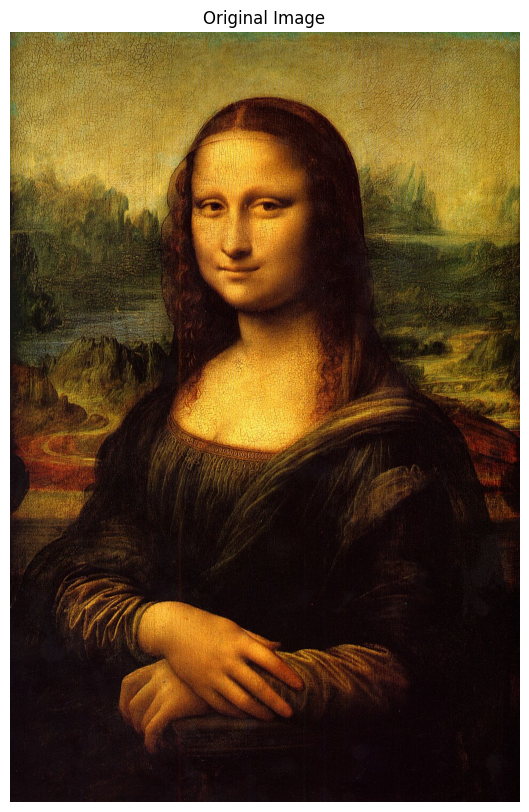

In [ ]:
#function to load the image from the specified path and return as a numpy array
def load_image(path):
    img = Image.open(path)
    return np.array(img)
#we also want to display the image in the notebook with the title
def display_image(img, title="Image"):
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)#displaying color img using matplotlib
    else:
        plt.imshow(img, cmap='gray')#same for grayscale image with gray colormap
    plt.title(title)
    plt.axis('off')
    plt.show()

#this is the file path of our image
image_path = "D:\\LABS\\DIP\\222.jpg"
img = load_image(image_path) #then the image is loaded
display_image(img, "Original Image")

## RGB to YCbCr Color Space Conversion

The JPEG algorithm converts RGB images to YCbCr color space, separating brightness (Y) from color information (Cb, Cr).
This separation allows us to compress the color information more aggressively than the brightness information,
which the human eye is more sensitive to.

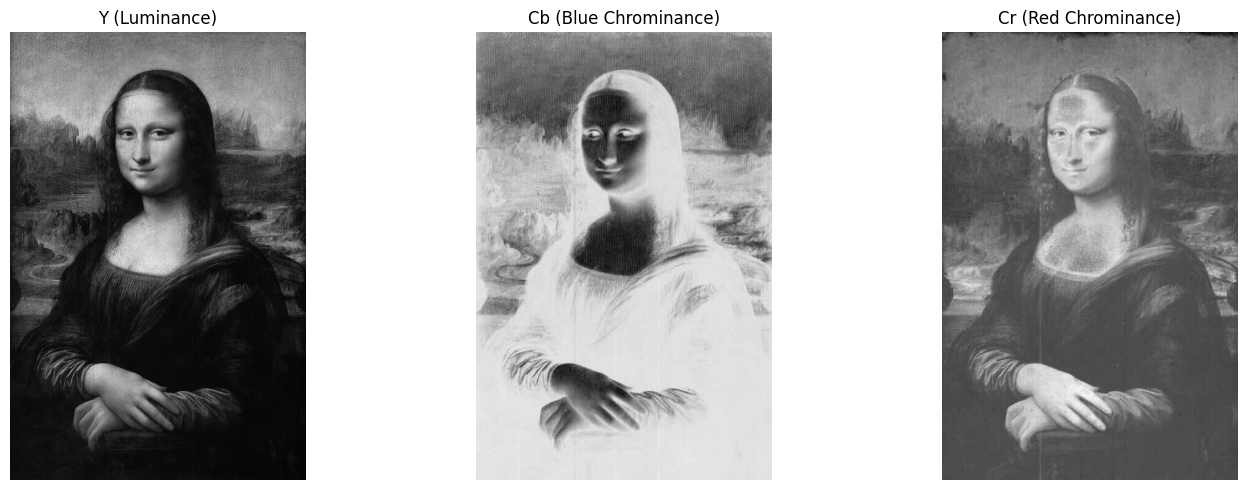

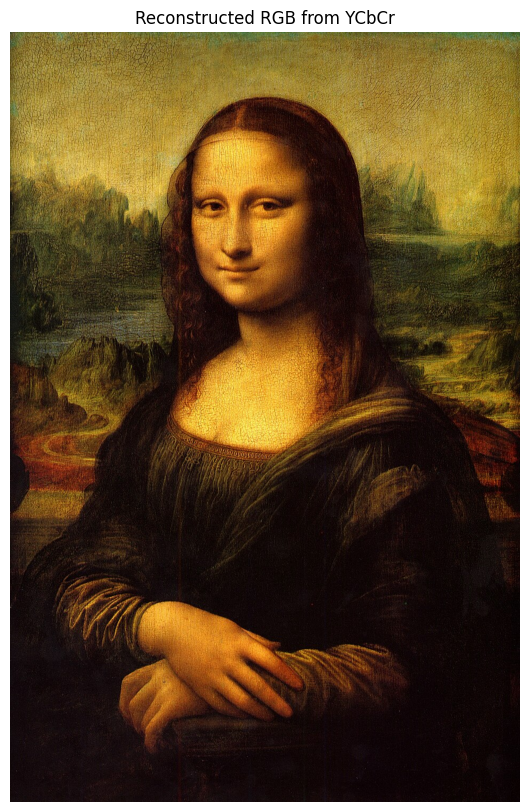

In [ ]:
#this function converts an RGB image to YCbCr color space and separates the Y, Cb, and Cr components
def rgb_to_ycbcr(img): 
#we input RGB img as numpy array with values in range 0-255

    #Make sure we're working with float values for precision
    img = img.astype(np.float32)
    
    #RGB to YCbCr conversion matrix
    transform = np.array([
        [ 0.299,  0.587,  0.114],
        [-0.169, -0.331,  0.500],
        [ 0.500, -0.419, -0.081]
    ])
    
    #Offset for Cb and Cr components
    offset = np.array([0, 128, 128])
    
    #then we reshape the image to a 2D array of pixels
    height, width, _ = img.shape
    pixels = img.reshape(-1, 3)
    
    #and apply the transformation
    ycbcr_pixels = np.dot(pixels, transform.T) + offset
    
    #Reshape back to the original image shape
    ycbcr = ycbcr_pixels.reshape(height, width, 3)
    
    #then simply extracted Y, Cb, Cr components
    Y = ycbcr[:, :, 0]
    Cb = ycbcr[:, :, 1]
    Cr = ycbcr[:, :, 2]
    
    return Y, Cb, Cr #and then returned them as individual components

#then we also define a function to convert YCbCr back to RGB as is needed
def ycbcr_to_rgb(Y, Cb, Cr):
#it will take Y, Cb, Cr components as input and return the RGB image

    #we have to reshape components to have the same dimensions
    height, width = Y.shape
    Y_reshaped = Y.reshape(height, width, 1)
    Cb_reshaped = Cb.reshape(height, width, 1)
    Cr_reshaped = Cr.reshape(height, width, 1)
    
    #then we combine into a single array
    ycbcr = np.concatenate([Y_reshaped, Cb_reshaped, Cr_reshaped], axis=2)
    
    #and apply YCbCr to RGB inverse transformation
    transform = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344, -0.714],
        [1.0, 1.772, 0.0]
    ])
    
    #Offset for Cb and Cr components
    offset = np.array([0, -128, -128])
    
    #Reshape to apply transformation
    pixels = ycbcr.reshape(-1, 3)
    
    #Apply the inverse transformation
    rgb_pixels = np.dot(pixels + offset, transform.T)
    
    #Clip values to stay in 0-255 range
    rgb_pixels = np.clip(rgb_pixels, 0, 255)
    
    #then reshape back to original dimensions and convert to uint8
    rgb = rgb_pixels.reshape(height, width, 3).astype(np.uint8)
    
    return rgb

# Convert our test image from RGB to YCbCr
Y, Cb, Cr = rgb_to_ycbcr(img)
###########################################################################
#then we display each component individually
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Y, cmap='gray')
plt.title('Y (Luminance)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Cb, cmap='gray')
plt.title('Cb (Blue Chrominance)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Cr, cmap='gray')
plt.title('Cr (Red Chrominance)')
plt.axis('off')

plt.tight_layout()
plt.show()
###########################################################################
#Convert back to RGB to verify our conversion works
rgb_reconstructed = ycbcr_to_rgb(Y, Cb, Cr)
display_image(rgb_reconstructed, "Reconstructed RGB from YCbCr")

## Chrominance Downsampling

In JPEG compression, we can reduce the resolution of the chrominance channels (Cb, Cr) while maintaining the full resolution 
of the luminance channel (Y). This is because human vision is more sensitive to brightness changes than to color changes.
We'll implement 4:2:0 downsampling, which reduces both horizontal and vertical resolution by a factor of 2.

Original chrominance dimensions: (1452, 960)
Downsampled chrominance dimensions: (726, 480)
Compression ratio for chrominance: 4.00x


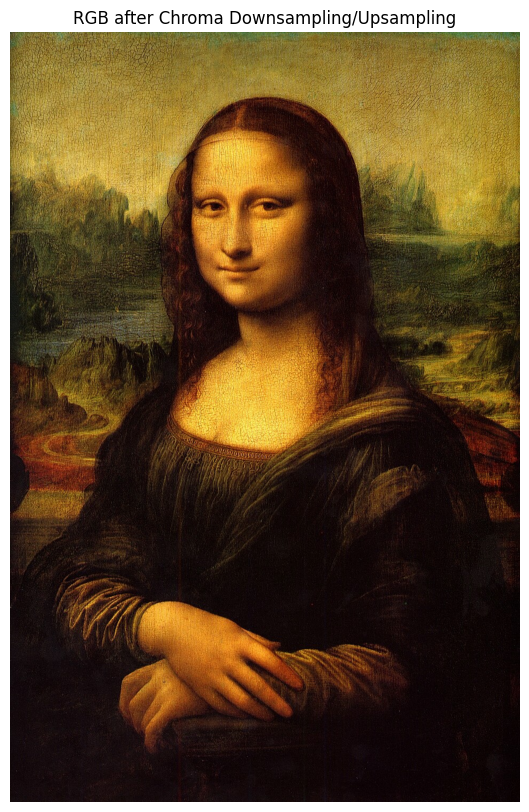

In [ ]:
# Now we will perform chroma subsampling (4:2:0) on the Cb and Cr channels
def downsample_chroma(cb, cr):
    #the chrominance components will be taken as parameters as numpy arrays
    #and return the downsampled Cb and Cr channels
    #first we get the dimensions of the chrominance channels
    height, width = cb.shape
    #Ensure even dimensions
    height_even = height - (height % 2)
    width_even = width - (width % 2)
    
    #Reshape to group 2x2 blocks and take their average
    cb_view = cb[:height_even, :width_even].reshape(height_even//2, 2, width_even//2, 2)
    cr_view = cr[:height_even, :width_even].reshape(height_even//2, 2, width_even//2, 2)
    #Average each 2x2 block to get downsampled values
    cb_downsampled = cb_view.mean(axis=(1, 3))
    cr_downsampled = cr_view.mean(axis=(1, 3))
    
    return cb_downsampled, cr_downsampled

#this function will take the downsampled chrominance channels and upsample them back to the original resolution
def upsample_chroma(cb_downsampled, cr_downsampled, original_shape):
    #first we make the output arrays
    height, width = original_shape
    cb_upsampled = np.zeros(original_shape, dtype=np.float32)
    cr_upsampled = np.zeros(original_shape, dtype=np.float32)
    
    #Simple nearest-neighbor upsampling
    for i in range(height):
        for j in range(width):
            # Find corresponding position in downsampled image
            ds_i = min(i // 2, cb_downsampled.shape[0] - 1)
            ds_j = min(j // 2, cb_downsampled.shape[1] - 1)
            
            cb_upsampled[i, j] = cb_downsampled[ds_i, ds_j]
            cr_upsampled[i, j] = cr_downsampled[ds_i, ds_j]
    
    return cb_upsampled, cr_upsampled

#Downsample the chrominance channels
Cb_downsampled, Cr_downsampled = downsample_chroma(Cb, Cr)
#then we print original and downsampled dimensions to understand compression effect
print(f"Original chrominance dimensions: {Cb.shape}")
print(f"Downsampled chrominance dimensions: {Cb_downsampled.shape}")
print(f"Compression ratio for chrominance: {Cb.size / Cb_downsampled.size:.2f}x")

#Upsample the chrominance channels back to original resolution
Cb_upsampled, Cr_upsampled = upsample_chroma(Cb_downsampled, Cr_downsampled, Cb.shape)

#Reconstruct RGB image with downsampled and then upsampled chrominance
rgb_with_downsampling = ycbcr_to_rgb(Y, Cb_upsampled, Cr_upsampled)
display_image(rgb_with_downsampling, "RGB after Chroma Downsampling/Upsampling")

## Divide Image into 8×8 Blocks

The JPEG algorithm processes images in 8×8 pixel blocks. This allows for efficient frequency analysis
and compression of local image regions.

Y channel shape: (1452, 960)
Y blocks shape: (182, 120, 8, 8)


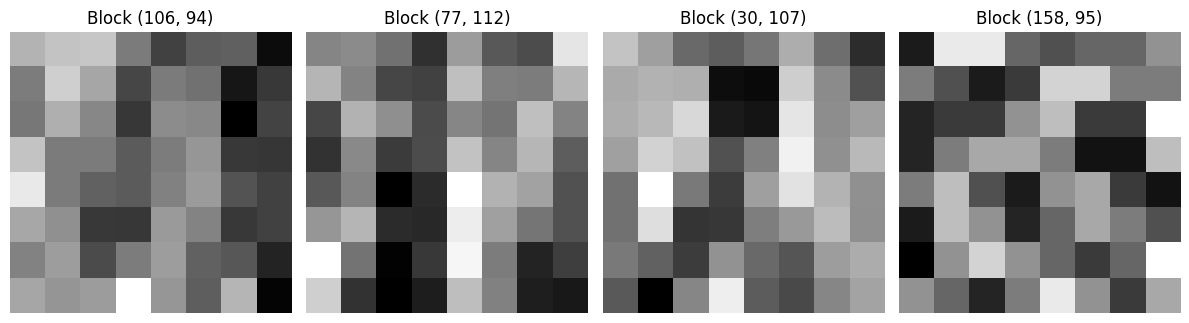

Recombined Y shape: (1452, 960)
Equal to original: True


In [ ]:
#function will pad the image dimensions to be multiples of 8
def pad_to_multiple_of_8(channel):
    #original height and width of the channel
    height, width = channel.shape
    #new dimensions that are the next multiple of 8 
    new_height = height + (8 - height % 8) % 8
    new_width = width + (8 - width % 8) % 8
    #a new padded array with zeros of the new size
    padded = np.zeros((new_height, new_width), dtype=channel.dtype)
    #copying the original data into padded
    padded[:height, :width] = channel
    #and then returning the padded array and original dimensions
    return padded, (height, width)

#this function will split the image channel into 8x8 blocks
def split_into_blocks(channel):
    #the channel will be taken as a parameter and return the blocks and original shape
    #padding the channel to have dimensions that are multiples of 8
    padded_channel, original_shape = pad_to_multiple_of_8(channel)

    #the padded dimensions
    height, width = padded_channel.shape
    
    #calculating number of blocks in each dimension
    num_blocks_v = height // 8
    num_blocks_h = width // 8
    
    #creating a 4D array view of the image, where each element is an 8x8 block
    blocks = padded_channel.reshape(num_blocks_v, 8, num_blocks_h, 8)
    blocks = blocks.transpose(0, 2, 1, 3)
    
    return blocks, original_shape

#this function will combine the 8x8 blocks back into a single channel
def combine_blocks(blocks, original_shape):
    #the blocks will be taken as a parameter and return the channel

    #Getting number of blocks in each dimension
    num_blocks_v, num_blocks_h = blocks.shape[0:2]
    
    #Calculating padded dimensions
    height_padded = num_blocks_v * 8
    width_padded = num_blocks_h * 8
    
    #reshaping blocks back to a 2D array
    blocks_transposed = blocks.transpose(0, 2, 1, 3)
    channel_padded = blocks_transposed.reshape(height_padded, width_padded)
    
    #crop to original dimensions
    height, width = original_shape
    channel = channel_padded[:height, :width]
    
    return channel

#splitting Y channel into 8x8 blocks
Y_blocks, Y_shape = split_into_blocks(Y)
print(f"Y channel shape: {Y.shape}")
print(f"Y blocks shape: {Y_blocks.shape}")
#################################################################
#we also visualized a few blocks
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    block_v = np.random.randint(0, Y_blocks.shape[0])
    block_h = np.random.randint(0, Y_blocks.shape[1])
    plt.imshow(Y_blocks[block_v, block_h], cmap='gray')
    plt.title(f"Block ({block_v}, {block_h})")
    plt.axis('off')
plt.tight_layout()
plt.show()

#then we recombined blocks to verify the process
Y_recombined = combine_blocks(Y_blocks, Y_shape)
print(f"Recombined Y shape: {Y_recombined.shape}")
print(f"Equal to original: {np.array_equal(Y[:Y_recombined.shape[0], :Y_recombined.shape[1]], Y_recombined)}")

## Apply Discrete Cosine Transform (DCT)

The Discrete Cosine Transform (DCT) converts the spatial pixel values into frequency coefficients.
This transformation is central to JPEG compression because it allows us to separate important 
visual information (lower frequencies) from less important details (higher frequencies).

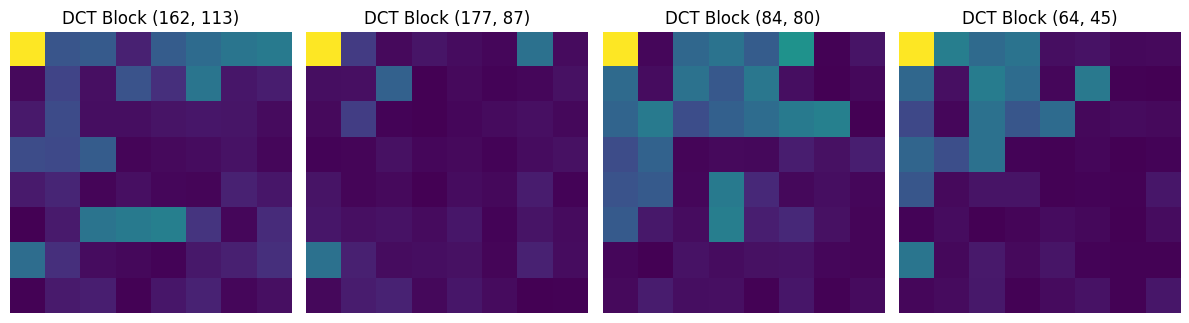

Mean reconstruction error after DCT and IDCT: 0.000006


In [ ]:
#this function will apply the Discrete Cosine Transform (DCT) to an 8x8 block
#and return the DCT coefficients
def apply_dct(block):
    #the block will be taken as a parameter and return the DCT coefficients
    #Shiftting values from [0, 255] to [-128, 127] before DCT
    shifted_block = block - 128.0
    
    #Applying 2D DCT
    dct_block = scipy.fftpack.dct(scipy.fftpack.dct(shifted_block, axis=0, norm='ortho'), 
                                axis=1, norm='ortho')
    
    return dct_block #and then we return the DCT coefficients

#this function will apply the Inverse Discrete Cosine Transform (IDCT) to an 8x8 block of DCT coefficients
#and return the reconstructed pixel values
def apply_idct(dct_block):
    #the dct_block will be taken as a parameter and return the reconstructed pixel values

    #Applying 2D IDCT
    idct_block = scipy.fftpack.idct(scipy.fftpack.idct(dct_block, axis=0, norm='ortho'), 
                                  axis=1, norm='ortho')
    
    #Shiftting values back to [0, 255] range
    block = idct_block + 128.0
    
    #Clipping values to valid range
    block = np.clip(block, 0, 255)
    
    return block #and then we return the reconstructed pixel values

#this function will apply DCT to all 8x8 blocks of the Y channel
#and return the DCT coefficients
def apply_dct_to_blocks(blocks):
    #the blocks will be taken as a parameter and return the DCT coefficients
    #getting number of blocks in each dimension
    num_blocks_v, num_blocks_h = blocks.shape[0:2]
    #creating a new array to store DCT coefficients
    dct_blocks = np.zeros_like(blocks, dtype=np.float32)
    #and then we apply DCT to each block
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            dct_blocks[v, h] = apply_dct(blocks[v, h])
    
    return dct_blocks

#this function will apply IDCT to all 8x8 blocks of DCT coefficients
#and return the reconstructed pixel values
def apply_idct_to_blocks(dct_blocks):
    #the dct_blocks will be taken as a parameter and return the reconstructed pixel values
    #getting number of blocks in each dimension
    num_blocks_v, num_blocks_h = dct_blocks.shape[0:2]
    #creating a new array to store reconstructed pixel values
    blocks = np.zeros_like(dct_blocks, dtype=np.float32)
    #and then we apply IDCT to each block
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            blocks[v, h] = apply_idct(dct_blocks[v, h])
    
    return blocks

#Applying DCT to Y blocks
Y_dct_blocks = apply_dct_to_blocks(Y_blocks)

#######################################################################
#we also displayed a few DCT blocks
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    block_v = np.random.randint(0, Y_dct_blocks.shape[0])
    block_h = np.random.randint(0, Y_dct_blocks.shape[1])
    # logarithmically scaled DCT coefficients used for better visualization
    plt.imshow(np.log(np.abs(Y_dct_blocks[block_v, block_h]) + 1), cmap='viridis')
    plt.title(f"DCT Block ({block_v}, {block_h})")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Applying IDCT and verify reconstruction
Y_reconstructed_blocks = apply_idct_to_blocks(Y_dct_blocks)
Y_reconstructed = combine_blocks(Y_reconstructed_blocks, Y_shape)

#Calculating reconstruction error
reconstruction_error = np.abs(Y[:Y_reconstructed.shape[0], :Y_reconstructed.shape[1]] - Y_reconstructed).mean()
print(f"Mean reconstruction error after DCT and IDCT: {reconstruction_error:.6f}")

## Quantization Process

Quantization is the main lossy step in JPEG compression. Each DCT coefficient is divided by a corresponding value
from a quantization table, and then rounded to the nearest integer. This discards high-frequency information
that is less perceptible to human vision, especially at higher compression ratios.

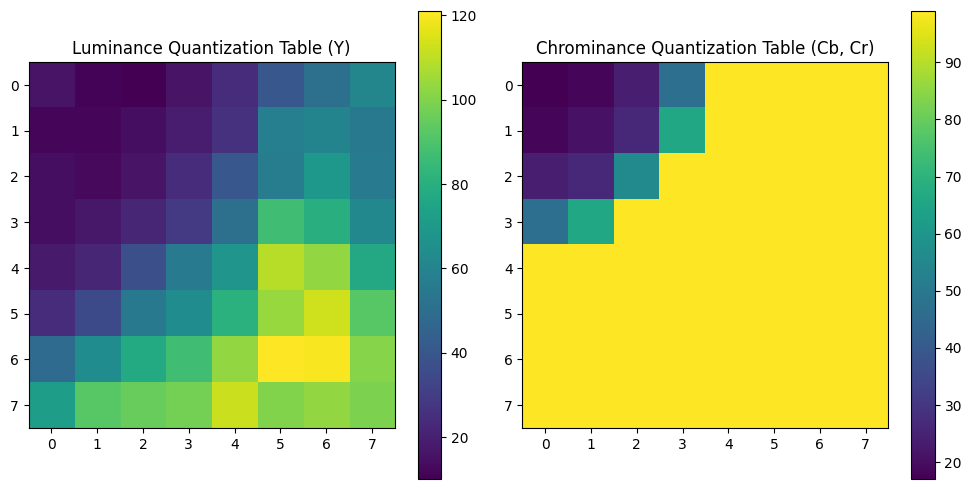

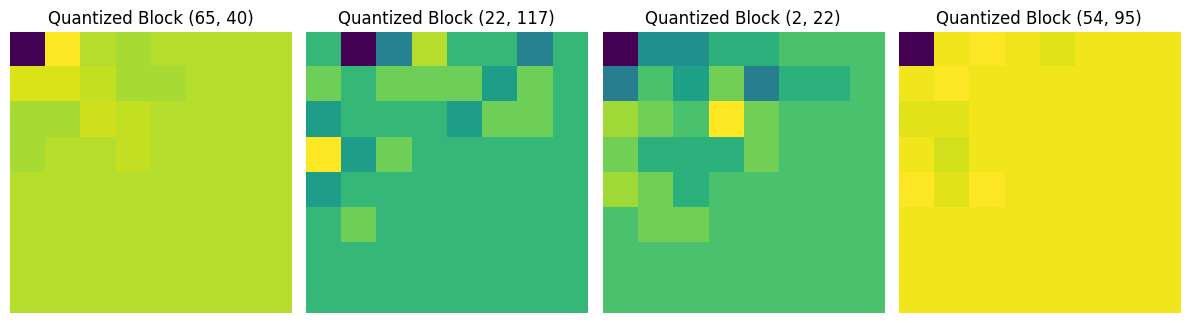

Percentage of zero coefficients after quantization: 80.35%


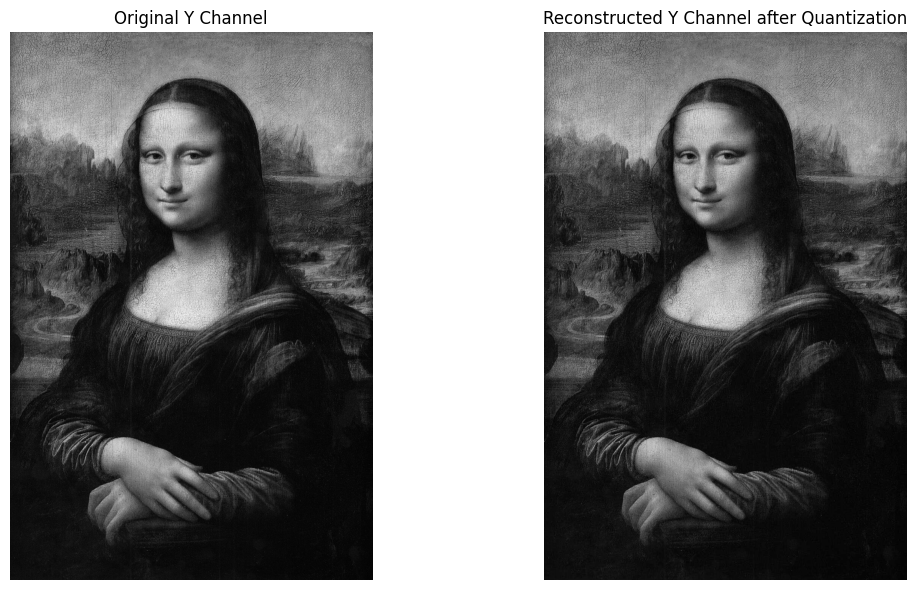

PSNR after quantization: 30.25 dB


In [ ]:
#Standard JPEG quantization tables
#These tables determine the compression quality
#and are used to quantize the DCT coefficients
def get_quantization_tables(quality=50):

    #Standard JPEG quantization tables
    y_table_base = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    #and the chrominance table
    c_table_base = np.array([
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ])
    #then we scale the tables according to the quality factor
    if quality < 50:
        scaling_factor = 5000 / quality
    else:
        scaling_factor = 200 - 2 * quality
    
    #Scaling the tables according to quality
    y_table = np.floor((y_table_base * scaling_factor + 50) / 100)
    c_table = np.floor((c_table_base * scaling_factor + 50) / 100)
    
    #Ensuring minimum value of 1
    y_table = np.clip(y_table, 1, 255).astype(np.uint8)
    c_table = np.clip(c_table, 1, 255).astype(np.uint8)
    #and then we return the quantization tables
    return y_table, c_table

#this function will quantize an 8x8 DCT block using a quantization table
#and return the quantized block
def quantize_block(dct_block, q_table):
    #the dct_block and q_table will be taken as parameters and return the quantized block
    return np.round(dct_block / q_table).astype(np.int32)

#this function will dequantize an 8x8 block of quantized DCT coefficients
#and return the DCT block
def dequantize_block(quantized_block, q_table):
#the quantized_block and q_table will be taken as parameters and return the DCT block
    return quantized_block * q_table

#this function will quantize all DCT blocks of a channel using the quantization table
def quantize_channel_blocks(dct_blocks, q_table):
    #the dct_blocks and q_table will be taken as parameters and return the quantized blocks
    num_blocks_v, num_blocks_h = dct_blocks.shape[0:2]
    quantized_blocks = np.zeros_like(dct_blocks, dtype=np.int32)
    #and then we quantize each block
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            quantized_blocks[v, h] = quantize_block(dct_blocks[v, h], q_table)
    #and then we return the quantized blocks
    return quantized_blocks

#this function will dequantize all blocks of a channel using the quantization table
def dequantize_channel_blocks(quantized_blocks, q_table):
#the quantized_blocks and q_table will be taken as parameters and return the DCT blocks
    num_blocks_v, num_blocks_h = quantized_blocks.shape[0:2]
    dct_blocks = np.zeros_like(quantized_blocks, dtype=np.float32)
    #and then we dequantize each block
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            dct_blocks[v, h] = dequantize_block(quantized_blocks[v, h], q_table)
    
    return dct_blocks

#getting quantization tables for quality factor of 50
y_qtable, c_qtable = get_quantization_tables(quality=50)
###########################################################################
#then we display the quantization tables
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_qtable, cmap='viridis')
plt.title('Luminance Quantization Table (Y)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(c_qtable, cmap='viridis')
plt.title('Chrominance Quantization Table (Cb, Cr)')
plt.colorbar()

plt.tight_layout()
plt.show()

#Quantizing the Y channel DCT blocks
Y_quantized_blocks = quantize_channel_blocks(Y_dct_blocks, y_qtable)
###########################################################################
#Displaying a few quantized blocks
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    block_v = np.random.randint(0, Y_quantized_blocks.shape[0])
    block_h = np.random.randint(0, Y_quantized_blocks.shape[1])
    plt.imshow(Y_quantized_blocks[block_v, block_h], cmap='viridis')
    plt.title(f"Quantized Block ({block_v}, {block_h})")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Calculating the percentage of zero coefficients after quantization
zero_percentage = np.sum(Y_quantized_blocks == 0) / Y_quantized_blocks.size * 100
print(f"Percentage of zero coefficients after quantization: {zero_percentage:.2f}%")

#Dequantizing the Y channel blocks
Y_dequantized_blocks = dequantize_channel_blocks(Y_quantized_blocks, y_qtable)

#Applying IDCT and reconstruct the Y channel
Y_reconstructed_blocks_q = apply_idct_to_blocks(Y_dequantized_blocks)
Y_reconstructed_q = combine_blocks(Y_reconstructed_blocks_q, Y_shape)
###########################################################################
#Displaying original and reconstructed Y channel
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Y, cmap='gray')
plt.title('Original Y Channel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y_reconstructed_q, cmap='gray')
plt.title('Reconstructed Y Channel after Quantization')
plt.axis('off')

plt.tight_layout()
plt.show()
###########################################################################
#Calculating PSNR to measure quality
def calculate_psnr(original, compressed):
    #the original and compressed images will be taken as parameters and return the PSNR value
    mse = np.mean((original - compressed) ** 2)
    #if the mean squared error is zero, we return infinity (perfect match)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0 #maximum pixel value for 8-bit images
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))#and then we calculate PSNR
    return psnr

psnr_value = calculate_psnr(Y[:Y_reconstructed_q.shape[0], :Y_reconstructed_q.shape[1]], Y_reconstructed_q)
print(f"PSNR after quantization: {psnr_value:.2f} dB")

## Zig-Zag Scanning

After quantization, many DCT coefficients become zero, especially in high-frequency regions.
To efficiently encode this data, JPEG uses a zig-zag scanning pattern that orders coefficients
from low to high frequencies. This creates long runs of zeroes, which can be efficiently compressed.

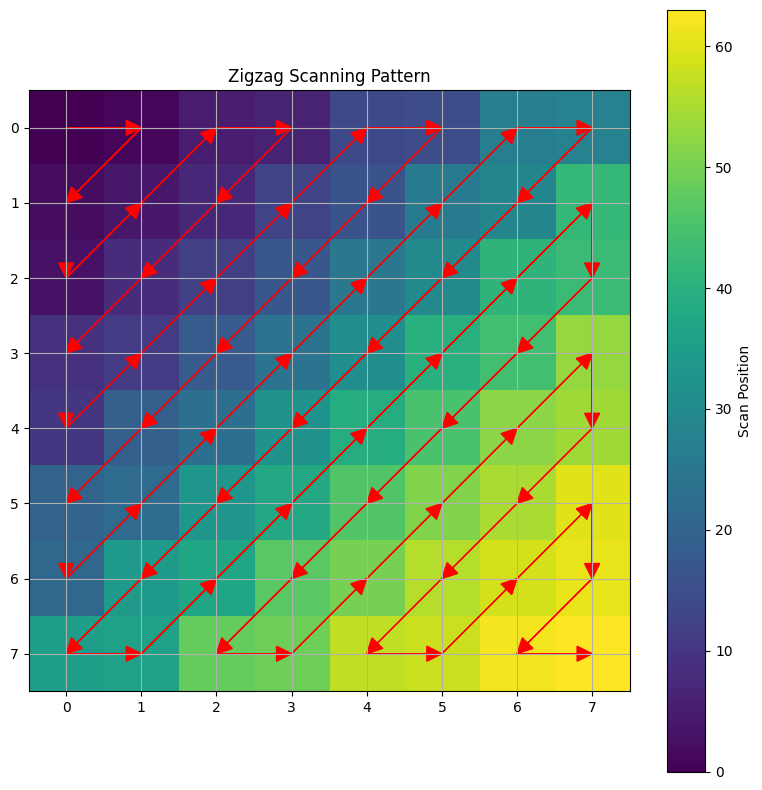

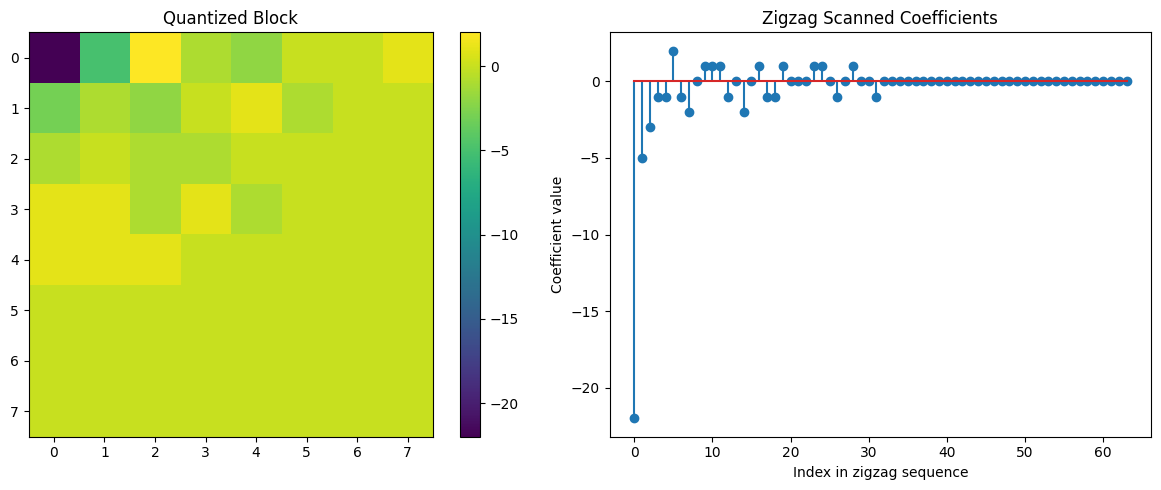

Average trailing zeros with zigzag scan: 31.36
Average trailing zeros with row scan: 26.90
Improvement ratio: 1.17x


In [ ]:
#this function will perform zigzag scanning on an 8x8 block to convert it to a 1D array
def zigzag_scan(block):

    #Creating a zigzag pattern of indices
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    
    #Flattening the block
    flat_block = block.flatten()
    
    #Creating the zigzag sequence
    zigzag = np.zeros_like(flat_block)
    #Filling the zigzag array using the zigzag pattern
    for i, idx in enumerate(zigzag_indices):
        zigzag[i] = flat_block[idx]
    
    return zigzag

#this function will perform inverse zigzag scanning to convert a 1D array back to an 8x8 block
def inverse_zigzag_scan(zigzag):
    #the zigzag will be taken as a parameter and return the 8x8 block
    #Creating a zigzag pattern of indices
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    
    #Creating an empty flattened block
    flat_block = np.zeros_like(zigzag)
    
    #Filling the flattened block using the zigzag sequence
    for i, idx in enumerate(zigzag_indices):
        flat_block[idx] = zigzag[i]
    
    #Reshaping to an 8x8 block
    block = flat_block.reshape(8, 8)
    
    return block

#function to visualize the zigzag scanning pattern
def plot_zigzag_pattern():
    #matrix with values in zigzag order
    zigzag_pattern = np.zeros((8, 8), dtype=int)
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    
    #Filling the matrix with values in increasing order
    for i, idx in enumerate(zigzag_indices):
        row, col = idx // 8, idx % 8
        zigzag_pattern[row, col] = i
    ##############################################################
    #Plotting the pattern
    plt.figure(figsize=(8, 8))
    plt.imshow(zigzag_pattern, cmap='viridis')
    plt.title('Zigzag Scanning Pattern')
    plt.colorbar(label='Scan Position')
    
    #Adding arrows to illustrate the path
    for i in range(len(zigzag_indices) - 1):
        #Get start and end indices for the arrow
        start_idx = zigzag_indices[i]
        end_idx = zigzag_indices[i + 1]
        start_row, start_col = start_idx // 8, start_idx % 8
        end_row, end_col = end_idx // 8, end_idx % 8
        plt.arrow(start_col, start_row, end_col - start_col, end_row - start_row, 
                  color='red', head_width=0.2, head_length=0.2, length_includes_head=True)
    
    plt.xticks(np.arange(8))
    plt.yticks(np.arange(8))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Displaying the zigzag pattern
plot_zigzag_pattern()

#Applying zigzag scanning to a quantized block and visualize
sample_block_v = 0
sample_block_h = 0
sample_block = Y_quantized_blocks[sample_block_v, sample_block_h]
zigzagged = zigzag_scan(sample_block)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_block, cmap='viridis')
plt.title('Quantized Block')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.stem(range(64), zigzagged)
plt.title('Zigzag Scanned Coefficients')
plt.xlabel('Index in zigzag sequence')
plt.ylabel('Coefficient value')

plt.tight_layout()
plt.show()
#############################################################################
#Analyzing the effectiveness of zigzag ordering for compression
#by comparing the number of trailing zeros in zigzag scan vs row scan
def count_trailing_zeros(arr):
    #the arr will be taken as a parameter and return the number of trailing zeros
    count = 0
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] == 0:
            count += 1
        else:
            break
        ##and then we return the count of trailing zeros
    return count

#Comparing the number of trailing zeros in zigzag scan vs row scan
num_samples = 100
zigzag_trailing_zeros = 0
row_trailing_zeros = 0
#and then we iterate over the blocks
for i in range(min(num_samples, Y_quantized_blocks.shape[0] * Y_quantized_blocks.shape[1])):
    v = i // Y_quantized_blocks.shape[1]
    h = i % Y_quantized_blocks.shape[1]
    block = Y_quantized_blocks[v, h]
    #and then we apply zigzag scan and flatten the block
    zigzag_arr = zigzag_scan(block)
    row_arr = block.flatten()
    
    zigzag_trailing_zeros += count_trailing_zeros(zigzag_arr)
    row_trailing_zeros += count_trailing_zeros(row_arr)
#and then we print the average number of trailing zeros
print(f"Average trailing zeros with zigzag scan: {zigzag_trailing_zeros / num_samples:.2f}")
print(f"Average trailing zeros with row scan: {row_trailing_zeros / num_samples:.2f}")
print(f"Improvement ratio: {zigzag_trailing_zeros / max(1, row_trailing_zeros):.2f}x")

## Run Length Encoding (RLE)

Run Length Encoding is used to compress the zigzag scanned coefficients by encoding runs of zeros.
In JPEG, a special form of RLE is used where only the zeros preceding non-zero coefficients are counted.

In [ ]:
#this function will perform Run-Length Encoding (RLE) on the zigzag scanned coefficients
def rle_encode(zigzag):

    rle = []# the RLE encoded data will be stored in this list
    
    #First coefficient (DC) is directly stored
    rle.append((0, zigzag[0]))
    
    #Encode AC coefficients (all the rest)
    i = 1
    while i < len(zigzag):
        #Count zeros
        run_length = 0
        while i < len(zigzag) and zigzag[i] == 0:
            run_length += 1
            i += 1
        
        #If we reached the end, add EOB marker
        if i >= len(zigzag):
            rle.append((0, 0))  #End of block marker
            break
        
        #Store the run length and the non-zero value
        rle.append((run_length, zigzag[i]))
        i += 1
    
    return rle

#this function will decode the RLE encoded data back to zigzag scanned coefficients
def rle_decode(rle, length=64):
   ##the rle will be taken as a parameter and return the zigzag scanned coefficients
    zigzag = np.zeros(length, dtype=int)
    #First coefficient is DC
    zigzag[0] = rle[0][1]
    
    #Decode AC coefficients
    pos = 1
    for i in range(1, len(rle)):
        run_length, value = rle[i]
        
        #If EOB marker, break
        if run_length == 0 and value == 0:
            break
        
        #skip zeros
        pos += run_length
        
        #Add non-zero value
        if pos < length:
            zigzag[pos] = value
        
        pos += 1
    
    return zigzag

#Applying RLE to a zigzag scanned block
sample_block = Y_quantized_blocks[0, 0]
zigzagged = zigzag_scan(sample_block)
rle_encoded = rle_encode(zigzagged)
#################################################################
print("Zigzag coefficients:")
print(zigzagged)
print("\nRLE encoded data:")
print(rle_encoded)

#Decode back and check if it matches
rle_decoded = rle_decode(rle_encoded)
print("\nRLE decoded data:")
print(rle_decoded)
print("\nReconstruction is perfect:", np.array_equal(zigzagged, rle_decoded))

#Calculating compression ratio achieved by RLE
def calculate_rle_compression_ratio(blocks):
#the blocks will be taken as a parameter and return the compression ratio
    total_elements = blocks.size
    total_rle_elements = 0
    #getting number of blocks in each dimension
    num_blocks_v, num_blocks_h = blocks.shape[0:2]
    #and then we iterate over the blocks
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            block = blocks[v, h]
            zigzagged = zigzag_scan(block)
            rle_encoded = rle_encode(zigzagged)
            total_rle_elements += len(rle_encoded) * 2  #Each RLE pair has 2 values
    #and then we calculate the compression ratio
    compression_ratio = total_elements / total_rle_elements
    return compression_ratio

#Calculating compression ratio for a subset of blocks for efficiency
compression_ratio = calculate_rle_compression_ratio(Y_quantized_blocks[:10, :10])
print(f"RLE compression ratio: {compression_ratio:.2f}x")

Zigzag coefficients:
[-22  -5  -3  -1  -1   2  -1  -2   0   1   1   1  -1   0  -2   0   1  -1
  -1   1   0   0   0   1   1   0  -1   0   1   0   0  -1   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

RLE encoded data:
[(0, -22), (0, -5), (0, -3), (0, -1), (0, -1), (0, 2), (0, -1), (0, -2), (1, 1), (0, 1), (0, 1), (0, -1), (1, -2), (1, 1), (0, -1), (0, -1), (0, 1), (3, 1), (0, 1), (1, -1), (1, 1), (2, -1), (0, 0)]

RLE decoded data:
[-22  -5  -3  -1  -1   2  -1  -2   0   1   1   1  -1   0  -2   0   1  -1
  -1   1   0   0   0   1   1   0  -1   0   1   0   0  -1   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Reconstruction is perfect: True
RLE compression ratio: 1.41x


## Huffman Coding

Huffman coding is the final stage of JPEG compression. It assigns variable-length codes to the RLE symbols,
with shorter codes for more frequent symbols. This provides additional lossless compression.

Sample of Huffman codes:
Symbol: (0, -1), Code: 00
Symbol: (0, 2), Code: 0100
Symbol: (0, -3), Code: 01010
Symbol: (2, 1), Code: 01011
Symbol: (0, 4), Code: 0110000

Original size (fixed-length): 368 bits
Huffman-encoded size: 94 bits
Compression ratio: 3.91x


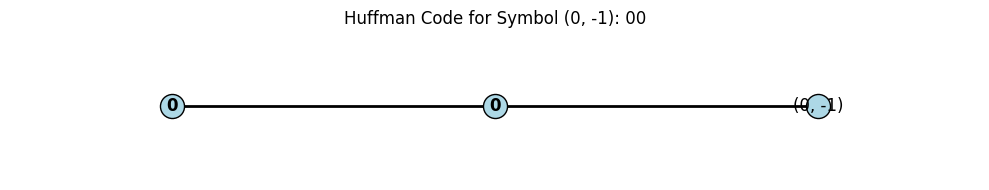

In [ ]:
#class to build a Huffman tree from symbol frequencies
class HuffmanNode:
    #initializer function
    def __init__(self, symbol=None, freq=0, left=None, right=None):
        self.symbol = symbol
        self.freq = freq
        self.left = left
        self.right = right
    ##comparison function for priority queue    
    def __lt__(self, other):
        return self.freq < other.freq

#this function will build the tree
def build_huffman_tree(symbol_frequencies):

    #Creating a leaf node for each symbol
    nodes = [HuffmanNode(symbol, freq) for symbol, freq in symbol_frequencies.items()]
    #Using a priority queue to build the tree
    heapq.heapify(nodes)
    
    #Combining nodes until only one (the root) remains
    while len(nodes) > 1:
        #Getting the two nodes with lowest frequency
        left = heapq.heappop(nodes)
        right = heapq.heappop(nodes)
        
        #Creating a new internal node with these two as children
        internal = HuffmanNode(None, left.freq + right.freq, left, right)
        heapq.heappush(nodes, internal)
    
    #Returning the root node
    return nodes[0] if nodes else None

#this function will generate Huffman codes from the tree
def generate_huffman_codes(root):
#the root will be taken as a parameter and return the Huffman codes
    codes = {}
    
    def traverse(node, code):# Traverse the tree to generate codes
        if node is None:
            return
        
        #If this is a leaf node, assign the code
        if node.symbol is not None:
            codes[node.symbol] = code
            return
        
        #Traversing left (add 0) and right (add 1)
        traverse(node.left, code + "0")
        traverse(node.right, code + "1")
    #and then we start traversing the tree
    traverse(root, "")
    return codes

#this function will encode the data using the generated Huffman codes
def huffman_encode(data, codes):
#the data and codes will be taken as parameters and return the encoded data
    encoded = ""
    for symbol in data:
        encoded += codes[symbol]
    return encoded

#this function will decode the encoded data using the Huffman tree
def huffman_decode(encoded, root):

    decoded = [] #the decoded data will be stored in this list
    node = root  # Starting from the root of the Huffman tree
    
    for bit in encoded:
        #Navigating left for 0, right for 1
        node = node.left if bit == "0" else node.right
        
        #If we reach a leaf node, add its symbol to the result
        if node.symbol is not None:
            decoded.append(node.symbol)
            node = root
    
    return decoded

#Collecting symbols from RLE-encoded data
rle_symbols = []

#Processing a subset of blocks for efficiency
max_blocks = 100
block_count = 0

#Iterating over the blocks
for v in range(Y_quantized_blocks.shape[0]):
    for h in range(Y_quantized_blocks.shape[1]):
        if block_count >= max_blocks:
            break
        #if block_count >= max_blocks:
        block = Y_quantized_blocks[v, h]
        zigzagged = zigzag_scan(block)
        rle_encoded = rle_encode(zigzagged)
        
        #Converting RLE pairs to symbols for Huffman coding
        for run_length, value in rle_encoded:
            rle_symbols.append((run_length, value))
        
        block_count += 1

#Counting the symbol frequencies
symbol_frequencies = Counter(rle_symbols)

#Building Huffman tree and generate codes
huffman_tree = build_huffman_tree(symbol_frequencies)
huffman_codes = generate_huffman_codes(huffman_tree)

#Displaying a sample of Huffman codes
print("Sample of Huffman codes:")
sample_count = 0
#and then we iterate over the symbols and codes
for symbol, code in huffman_codes.items():
    print(f"Symbol: {symbol}, Code: {code}")
    sample_count += 1
    if sample_count >= 5:
        break

#Encoding an example block with Huffman coding
example_block = Y_quantized_blocks[0, 0]
example_zigzagged = zigzag_scan(example_block)
example_rle = rle_encode(example_zigzagged)

#Calculating original bit size
original_bits = len(example_rle) * (8 + 8)  # Assuming 8 bits per run length and 8 bits per value

#Calculating Huffman-encoded bit size
huffman_encoded = huffman_encode(example_rle, huffman_codes)
huffman_bits = len(huffman_encoded)
######################################################################
print(f"\nOriginal size (fixed-length): {original_bits} bits")
print(f"Huffman-encoded size: {huffman_bits} bits")
print(f"Compression ratio: {original_bits / max(1, huffman_bits):.2f}x")

#Visualizing Huffman tree simplified for a single symbol
def plot_huffman_tree(symbol, code):
    #the symbol and code will be taken as parameters and return the plot
    plt.figure(figsize=(10, 2))
    #Drawing nodes
    x_positions = [i for i in range(len(code) + 1)]
    y_positions = [0] * (len(code) + 1)
    # Adding the symbol at the end
    plt.scatter(x_positions, y_positions, s=300, color='lightblue', edgecolor='black', zorder=2)
    #Drawing edges
    for i in range(len(code)):
        plt.plot([i, i+1], [0, 0], 'k-', linewidth=2, zorder=1)
    
    #Annotating nodes
    for i in range(len(code)):
        plt.text(i, 0, f"{code[i]}", ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.text(len(code), 0, f"{symbol}", ha='center', va='center', fontsize=12)
    
    plt.xlim(-0.5, len(code) + 0.5)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.title(f"Huffman Code for Symbol {symbol}: {code}")
    plt.tight_layout()
    plt.show()

#Showing Huffman code for a specific symbol
selected_symbol = list(huffman_codes.keys())[0]  #the first symbol
selected_code = huffman_codes[selected_symbol]
plot_huffman_tree(selected_symbol, selected_code)

In [ ]:
#this function will check if an image is grayscale
def is_grayscale(img):
    if len(img.shape) == 2: #Grayscale image has only one channel
        return True
    elif len(img.shape) == 3 and img.shape[2] == 1: #Single channel in 3D array
        return True
    elif len(img.shape) == 3 and img.shape[2] == 3: #RGB image with 3 channels
        #Checking if all color channels are equal
        return np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,0], img[:,:,2])
    return False


In [ ]:
#this function will convert an RGB image to grayscale using the luminosity method
#and return the grayscale image
def grayscale_jpeg_encode(image, quality=50):

    #Ensuring the image is grayscale
    gray = image
        
    #Making sure we have a 2D array
    if len(gray.shape) == 3:
        gray = gray[:,:,0]
    
    #Step 1: Splitting into 8x8 blocks
    gray_blocks, gray_shape = split_into_blocks(gray)
    
    #Step 2: Applying DCT to each block
    gray_dct_blocks = apply_dct_to_blocks(gray_blocks)
    
    #Step 3: Quantization (using luminance quantization table)
    y_qtable, _ = get_quantization_tables(quality)
    gray_quantized_blocks = quantize_channel_blocks(gray_dct_blocks, y_qtable)
    
    #Step 4: Zigzag scan and RLE
    gray_rle = []
    
    #Processing grayscale channel
    for v in range(gray_quantized_blocks.shape[0]):
        for h in range(gray_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(gray_quantized_blocks[v, h])
            gray_rle.append(rle_encode(zigzagged))
    
    #Collecting metadata for decoding
    encoded_data = {
        'gray_rle': gray_rle,
        'gray_shape': gray_shape,
        'y_qtable': y_qtable,
        'quality': quality,
        'original_shape': image.shape,
        'is_grayscale': True
    }
    
    return encoded_data #and then we return the encoded data

#this function will decode the grayscale JPEG encoded data
#and return the reconstructed grayscale image
def grayscale_jpeg_decode(encoded_data):
    #Extracting data and metadata
    gray_rle = encoded_data['gray_rle']
    gray_shape = encoded_data['gray_shape']
    y_qtable = encoded_data['y_qtable']
    original_shape = encoded_data['original_shape']
    
    #Step 1: RLE decode and inverse zigzag scan
    gray_blocks_shape = ((gray_shape[0] + 7) // 8, (gray_shape[1] + 7) // 8, 8, 8)
    gray_quantized_blocks = np.zeros(gray_blocks_shape, dtype=np.int32)
    
    #Processing grayscale channel
    block_idx = 0
    #Iterating over the blocks
    for v in range(gray_blocks_shape[0]):
        for h in range(gray_blocks_shape[1]):
            rle_data = gray_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            gray_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    #Step 2: Dequantization
    gray_dct_blocks = dequantize_channel_blocks(gray_quantized_blocks, y_qtable)
    
    #Step 3: Apply IDCT
    gray_blocks = apply_idct_to_blocks(gray_dct_blocks)
    
    #Step 4: Combine blocks
    gray_reconstructed = combine_blocks(gray_blocks, gray_shape)
    
    #Ensuring the output has the correct shape
    if len(original_shape) == 3 and original_shape[2] == 1:
        #Original was 3D with single channel
        decoded_image = gray_reconstructed[:original_shape[0], :original_shape[1]].reshape(original_shape)
    else:
        #Original was 2D
        decoded_image = gray_reconstructed[:original_shape[0], :original_shape[1]]
    #and then we return the decoded image
    return decoded_image

## Complete JPEG Encoder Function

Now we'll combine all the previous steps into a complete JPEG encoding function that takes an
image and returns compressed data, along with the information needed for decoding.

In [ ]:
#this function will encode an image using JPEG encoding
#and return the encoded data
def jpeg_encode(image, quality=50):

    #Step 1: Convert RGB to YCbCr
    Y, Cb, Cr = rgb_to_ycbcr(image)
    
    #Step 2: Chroma downsampling
    Cb_downsampled, Cr_downsampled = downsample_chroma(Cb, Cr)
    
    #Step 3: Split into 8x8 blocks
    Y_blocks, Y_shape = split_into_blocks(Y)
    Cb_blocks, Cb_shape = split_into_blocks(Cb_downsampled)
    Cr_blocks, Cr_shape = split_into_blocks(Cr_downsampled)
    
    #Step 4: Apply DCT to each block
    Y_dct_blocks = apply_dct_to_blocks(Y_blocks)
    Cb_dct_blocks = apply_dct_to_blocks(Cb_blocks)
    Cr_dct_blocks = apply_dct_to_blocks(Cr_blocks)
    
    #Step 5: Quantization
    y_qtable, c_qtable = get_quantization_tables(quality)
    Y_quantized_blocks = quantize_channel_blocks(Y_dct_blocks, y_qtable)
    Cb_quantized_blocks = quantize_channel_blocks(Cb_dct_blocks, c_qtable)
    Cr_quantized_blocks = quantize_channel_blocks(Cr_dct_blocks, c_qtable)
    
    #Step 6 & 7: Zigzag scan and RLE
    Y_rle = []
    Cb_rle = []
    Cr_rle = []
    
    #Processing Y channel
    for v in range(Y_quantized_blocks.shape[0]):
        #Iterating over the blocks
        for h in range(Y_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Y_quantized_blocks[v, h])
            Y_rle.append(rle_encode(zigzagged))
    
    #Process Cb channel
    for v in range(Cb_quantized_blocks.shape[0]):
        for h in range(Cb_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Cb_quantized_blocks[v, h])
            Cb_rle.append(rle_encode(zigzagged))
    
    #Process Cr channel
    for v in range(Cr_quantized_blocks.shape[0]):
        for h in range(Cr_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Cr_quantized_blocks[v, h])
            Cr_rle.append(rle_encode(zigzagged))
    
    #For a complete implementation, step 8 (Huffman coding) would be applied here
    #This is simplified for clarity
    
    #Collecting metadata for decoding
    encoded_data = {
        'Y_rle': Y_rle, #Y channel RLE data
        'Cb_rle': Cb_rle, #Cb channel RLE data
        'Cr_rle': Cr_rle, #Cr channel RLE data
        'Y_shape': Y_shape, #Y channel shape
        'Cb_shape': Cb_shape, #Cb channel shape
        'Cr_shape': Cr_shape, #Cr channel shape
        'y_qtable': y_qtable, #Luminance quantization table
        'c_qtable': c_qtable, #Chrominance quantization table
        'quality': quality,   #Quality factor
        'original_shape': image.shape  # Original image shape
    }
    
    return encoded_data

#this function will decode the JPEG encoded data
def jpeg_decode(encoded_data):

    #Extracting the data and metadata
    Y_rle = encoded_data['Y_rle']
    Cb_rle = encoded_data['Cb_rle']
    Cr_rle = encoded_data['Cr_rle']
    Y_shape = encoded_data['Y_shape']
    Cb_shape = encoded_data['Cb_shape']
    Cr_shape = encoded_data['Cr_shape']
    y_qtable = encoded_data['y_qtable']
    c_qtable = encoded_data['c_qtable']
    original_shape = encoded_data['original_shape']
    
    #For a complete implementation, Huffman decoding would be applied here
    
    #Step 1: RLE decode and inverse zigzag scan
    Y_blocks_shape = (Y_shape[0] + 7) // 8, (Y_shape[1] + 7) // 8, 8, 8
    Cb_blocks_shape = (Cb_shape[0] + 7) // 8, (Cb_shape[1] + 7) // 8, 8, 8
    Cr_blocks_shape = (Cr_shape[0] + 7) // 8, (Cr_shape[1] + 7) // 8, 8, 8
    
    Y_quantized_blocks = np.zeros(Y_blocks_shape, dtype=np.int32)
    Cb_quantized_blocks = np.zeros(Cb_blocks_shape, dtype=np.int32)
    Cr_quantized_blocks = np.zeros(Cr_blocks_shape, dtype=np.int32)
    
    #Processing Y channel
    block_idx = 0
    for v in range(Y_blocks_shape[0]):
        for h in range(Y_blocks_shape[1]):
            rle_data = Y_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Y_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    #Processing Cb channel
    block_idx = 0
    for v in range(Cb_blocks_shape[0]):
        for h in range(Cb_blocks_shape[1]):
            rle_data = Cb_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Cb_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    #Processing Cr channel
    block_idx = 0
    for v in range(Cr_blocks_shape[0]):
        for h in range(Cr_blocks_shape[1]):
            rle_data = Cr_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Cr_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    #Step 2: Dequantization
    Y_dct_blocks = dequantize_channel_blocks(Y_quantized_blocks, y_qtable)
    Cb_dct_blocks = dequantize_channel_blocks(Cb_quantized_blocks, c_qtable)
    Cr_dct_blocks = dequantize_channel_blocks(Cr_quantized_blocks, c_qtable)
    
    #Step 3: Apply IDCT
    Y_blocks = apply_idct_to_blocks(Y_dct_blocks)
    Cb_blocks = apply_idct_to_blocks(Cb_dct_blocks)
    Cr_blocks = apply_idct_to_blocks(Cr_dct_blocks)
    
    #Step 4: Combine blocks
    Y_reconstructed = combine_blocks(Y_blocks, Y_shape)
    Cb_downsampled = combine_blocks(Cb_blocks, Cb_shape)
    Cr_downsampled = combine_blocks(Cr_blocks, Cr_shape)
    
    #Step 5: Chroma upsampling
    Cb_upsampled, Cr_upsampled = upsample_chroma(Cb_downsampled, Cr_downsampled, Y_shape)
    
    #Step 6: Convert YCbCr to RGB
    decoded_image = ycbcr_to_rgb(Y_reconstructed, Cb_upsampled, Cr_upsampled)
    
    #Crop to original dimensions
    decoded_image = decoded_image[:original_shape[0], :original_shape[1], :original_shape[2]]
    
    return decoded_image#and then we return the decoded image


In [ ]:
#this function will compress an image using JPEG encoding
def jpeg_compress(image, quality=50):
    #the image and quality will be taken as parameters and return the compressed data
    if is_grayscale(image): #Check if the image is grayscale
        return grayscale_jpeg_encode(image, quality)
    else: #If not grayscale, use standard JPEG encoding
        return jpeg_encode(image, quality)

#this function will decompress an image using JPEG decoding
def jpeg_decompress(encoded_data):
    #the encoded_data will be taken as a parameter and return the decompressed image
    if 'is_grayscale' in encoded_data and encoded_data['is_grayscale']:
        return grayscale_jpeg_decode(encoded_data)
    else:
        #If not grayscale, use standard JPEG decoding
        return jpeg_decode(encoded_data)

Encoding completed in 2.66 seconds
Image processed as: Color
Original size: 4181760 bytes
Estimated compressed size: 657814 bytes
Compression ratio: 6.36x
Decoding completed in 2.56 seconds


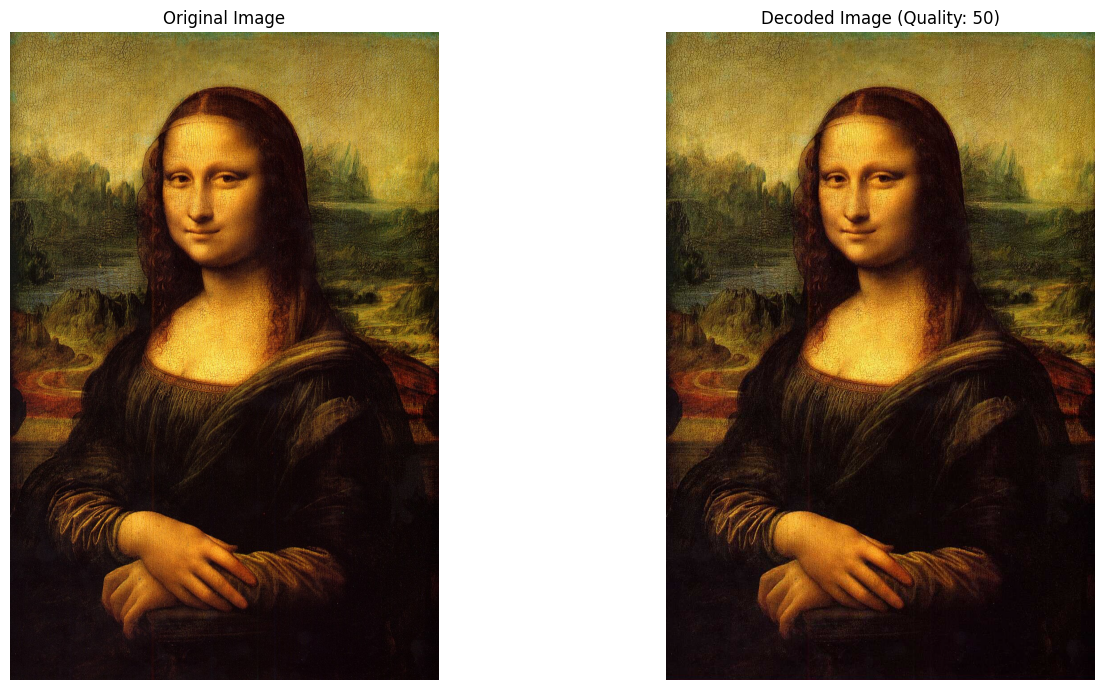

PSNR: 31.64 dB


In [ ]:
#Encoding our test image using the universal function that handles both color and grayscale
t_start = time.time()
encoded_data = jpeg_compress(img, quality=50)
encode_time = time.time() - t_start

print(f"Encoding completed in {encode_time:.2f} seconds")
is_gray = 'is_grayscale' in encoded_data and encoded_data['is_grayscale']
print(f"Image processed as: {'Grayscale' if is_gray else 'Color'}")

#Calculating approximate size of encoded data (updated to handle both color and grayscale)
def estimate_compressed_size(encoded_data):
    #the encoded_data will be taken as a parameter and return the estimated size
    if 'is_grayscale' in encoded_data and encoded_data['is_grayscale']:
        #Handle grayscale case
        gray_pairs = sum(len(block) for block in encoded_data['gray_rle'])
        total_pairs = gray_pairs
        #Just one quantization table for grayscale
        metadata_size = 64 + 50
    else:
        #Handle color case
        y_pairs = sum(len(block) for block in encoded_data['Y_rle'])
        cb_pairs = sum(len(block) for block in encoded_data['Cb_rle'])
        cr_pairs = sum(len(block) for block in encoded_data['Cr_rle'])
        total_pairs = y_pairs + cb_pairs + cr_pairs
        #Two quantization tables for color
        metadata_size = 64 * 2 + 100
        
    #Assuming each RLE pair requires on average 2 bytes after Huffman coding
    estimated_size = total_pairs * 2 + metadata_size
    
    return estimated_size

#Calculating compression ratio
original_size = img.size * img.itemsize
compressed_size = estimate_compressed_size(encoded_data)
compression_ratio = original_size / compressed_size

print(f"Original size: {original_size} bytes")
print(f"Estimated compressed size: {compressed_size} bytes")
print(f"Compression ratio: {compression_ratio:.2f}x")

#Decoding the image using the universal function
t_start = time.time()
decoded_image = jpeg_decompress(encoded_data)
decode_time = time.time() - t_start

print(f"Decoding completed in {decode_time:.2f} seconds")

#####################################################################
#Displaying original and decoded images
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray' if is_gray else None)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(decoded_image, cmap='gray' if is_gray else None)
plt.title(f'Decoded Image (Quality: 50)')
plt.axis('off')

plt.tight_layout()
plt.show()
#####################################################################

#Calculating PSNR for the whole image
psnr = calculate_psnr(img, decoded_image)
print(f"PSNR: {psnr:.2f} dB")

##  GUI - LAST

In [1]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from collections import Counter
import heapq
import struct
import numpy as np
import bitarray
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import scipy.fftpack
import pickle
import time
import os
import io


class JpegCompressionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("JPEG Compression Tool")
        self.root.geometry("1100x750")
        
        self.input_image = None
        self.encoded_data = None
        self.decoded_image = None
        self.quality = tk.IntVar(value=50)
        self.force_grayscale = tk.BooleanVar(value=False)
        self.original_file_size = 0
        
        # Create the main frame
        self.main_frame = ttk.Frame(root, padding="10")
        self.main_frame.pack(fill=tk.BOTH, expand=True)

        self.tab_control = ttk.Notebook(self.main_frame)
        
        self.encode_tab = ttk.Frame(self.tab_control)
        self.decode_tab = ttk.Frame(self.tab_control)
        
        self.tab_control.add(self.encode_tab, text="Encode")
        self.tab_control.add(self.decode_tab, text="Decode")
        self.tab_control.pack(expand=1, fill=tk.BOTH)
        
        # Setup encode tab
        self.setup_encode_tab()
        
        # Setup decode tab
        self.setup_decode_tab()
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(root, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)

    def setup_encode_tab(self):
        # Create frames
        control_frame = ttk.LabelFrame(self.encode_tab, text="Controls", padding="10")
        control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)
        
        image_frame = ttk.LabelFrame(self.encode_tab, text="Images", padding="10")
        image_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Controls
        ttk.Button(control_frame, text="Load Image", command=self.load_image).pack(fill=tk.X, pady=5)
        
        # Quality control
        quality_frame = ttk.Frame(control_frame)
        quality_frame.pack(fill=tk.X, pady=10)
        ttk.Label(quality_frame, text="Quality:").pack(side=tk.LEFT)
        ttk.Label(quality_frame, textvariable=self.quality).pack(side=tk.RIGHT)
        
        quality_scale = ttk.Scale(control_frame, from_=1, to=100, orient=tk.HORIZONTAL, 
                                 variable=self.quality, command=lambda s: self.quality.set(int(float(s))))
        quality_scale.pack(fill=tk.X, pady=5)
        
        # Grayscale option
        ttk.Checkbutton(control_frame, text="Force Grayscale", variable=self.force_grayscale).pack(anchor=tk.W, pady=5)
        
        # Action buttons
        ttk.Button(control_frame, text="Encode", command=self.encode_action).pack(fill=tk.X, pady=10)
        ttk.Button(control_frame, text="Save Encoded Data", command=self.save_encoded_data).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Save Decoded Image", command=self.save_decoded_image).pack(fill=tk.X, pady=5)
        
        # Information frame
        info_frame = ttk.LabelFrame(control_frame, text="File Information")
        info_frame.pack(fill=tk.X, pady=10)
        
        self.original_size_var = tk.StringVar(value="Original Size: N/A")
        self.encoded_size_var = tk.StringVar(value="Encoded Size: N/A")
        self.compression_ratio_var = tk.StringVar(value="Compression Ratio: N/A")
        self.psnr_var = tk.StringVar(value="PSNR: N/A")
        
        ttk.Label(info_frame, textvariable=self.original_size_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.encoded_size_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.compression_ratio_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.psnr_var).pack(anchor=tk.W, pady=2)
        
        # Image display area
        self.image_display_frame = ttk.Frame(image_frame)
        self.image_display_frame.pack(fill=tk.BOTH, expand=True)
        
        # Original image
        self.original_image_frame = ttk.LabelFrame(self.image_display_frame, text="Original Image")
        self.original_image_frame.grid(row=0, column=0, padx=5, pady=5, sticky="nsew")
        
        self.original_canvas = tk.Canvas(self.original_image_frame)
        self.original_canvas.pack(fill=tk.BOTH, expand=True)
        
        # Decoded image
        self.decoded_image_frame = ttk.LabelFrame(self.image_display_frame, text="Decoded Image")
        self.decoded_image_frame.grid(row=0, column=1, padx=5, pady=5, sticky="nsew")
        
        self.decoded_canvas = tk.Canvas(self.decoded_image_frame)
        self.decoded_canvas.pack(fill=tk.BOTH, expand=True)
        
        # Configure grid weights
        self.image_display_frame.grid_rowconfigure(0, weight=1)
        self.image_display_frame.grid_columnconfigure(0, weight=1)
        self.image_display_frame.grid_columnconfigure(1, weight=1)

    def setup_decode_tab(self):
        # Create frames
        control_frame = ttk.LabelFrame(self.decode_tab, text="Controls", padding="10")
        control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)
        
        image_frame = ttk.LabelFrame(self.decode_tab, text="Decoded Image", padding="10")
        image_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Controls
        ttk.Button(control_frame, text="Load Encoded Data", command=self.load_encoded_data).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Decode", command=self.decode_action).pack(fill=tk.X, pady=10)
        ttk.Button(control_frame, text="Save Decoded Image", command=self.save_decoded_image).pack(fill=tk.X, pady=5)
        
        # Information frame
        info_frame = ttk.LabelFrame(control_frame, text="File Information")
        info_frame.pack(fill=tk.X, pady=10)
        
        self.decode_encoded_size_var = tk.StringVar(value="Encoded Size: N/A")
        self.decode_decoded_size_var = tk.StringVar(value="Decoded Size: N/A")
        self.decode_type_var = tk.StringVar(value="Image Type: N/A")
        self.decode_quality_var = tk.StringVar(value="Quality: N/A")
        
        ttk.Label(info_frame, textvariable=self.decode_encoded_size_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.decode_decoded_size_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.decode_type_var).pack(anchor=tk.W, pady=2)
        ttk.Label(info_frame, textvariable=self.decode_quality_var).pack(anchor=tk.W, pady=2)
        
        # Image display
        self.decode_canvas = tk.Canvas(image_frame)
        self.decode_canvas.pack(fill=tk.BOTH, expand=True)

    def load_image(self):
        file_path = filedialog.askopenfilename(
            title="Select Image File",
            filetypes=[("Image Files", "*.png *.jpg *.jpeg *.bmp *.tiff")]
        )
        
        if file_path:
            try:
                self.status_var.set(f"Loading image: {file_path}")
                self.root.update()
                
                # Load image
                self.input_image = self.load_image_from_path(file_path)
                
                # Display image
                self.display_image_on_canvas(self.input_image, self.original_canvas)
                
                # Store the original file size
                self.original_file_size = os.path.getsize(file_path)
                self.original_size_var.set(f"Original Size: {self.format_file_size(self.original_file_size)}")
                
                # Clear decoded image
                self.decoded_image = None
                self.decoded_canvas.delete("all")
                
                # Reset stats
                self.encoded_size_var.set("Encoded Size: N/A")
                self.compression_ratio_var.set("Compression Ratio: N/A")
                self.psnr_var.set("PSNR: N/A")
                
                # Auto-detect grayscale
                if self.is_grayscale_image(self.input_image):
                    self.force_grayscale.set(True)
                
                self.status_var.set(f"Image loaded: {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load image: {str(e)}")
                self.status_var.set("Failed to load image")

    def encode_action(self):
        if self.input_image is None:
            messagebox.showwarning("Warning", "Please load an image first")
            return
        
        try:
            self.status_var.set("Encoding image...")
            self.root.update()
            
            # Prepare image
            img = self.input_image.copy()
            
            # Convert to grayscale if requested
            if self.force_grayscale.get() and not self.is_grayscale_image(img):
                if len(img.shape) == 3 and img.shape[2] == 3:
                    # Convert RGB to grayscale
                    Y, _, _ = rgb_to_ycbcr(img)
                    img = Y.astype(np.uint8)
            
            # Start timing
            start_time = time.time()
            
            # Encode the image
            self.encoded_data = jpeg_compress(img, quality=self.quality.get())
            
            # End timing
            encode_time = time.time() - start_time
            
            # Decode for display
            start_time = time.time()
            self.decoded_image = jpeg_decompress(self.encoded_data)
            decode_time = time.time() - start_time
            
            # Display decoded image
            self.display_image_on_canvas(self.decoded_image, self.decoded_canvas)
            
            # Calculate stats
            # Use the stored original file size instead of recalculating
            original_size = self.original_file_size
            encoded_size = estimate_compressed_size(self.encoded_data)
            compression_ratio = original_size / encoded_size if encoded_size > 0 else 0
            
            # Calculate PSNR
            psnr = calculate_psnr(img, self.decoded_image)
            
            # Update info using stored original size
            self.original_size_var.set(f"Original Size: {self.format_file_size(original_size)}")
            self.encoded_size_var.set(f"Encoded Size: {self.format_file_size(encoded_size)}")
            self.compression_ratio_var.set(f"Compression Ratio: {compression_ratio:.2f}x")
            self.psnr_var.set(f"PSNR: {psnr:.2f} dB")
            
            self.status_var.set(f"Image encoded in {encode_time:.2f}s and decoded in {decode_time:.2f}s")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to encode image: {str(e)}")
            self.status_var.set("Failed to encode image")
            import traceback
            traceback.print_exc()

    def save_encoded_data(self):
        if self.encoded_data is None:
            messagebox.showwarning("Warning", "Please encode an image first")
            return
        
        file_path = filedialog.asksaveasfilename(
            title="Save Encoded Data",
            defaultextension=".jpgc",
            filetypes=[("JPEG Compressed", "*.jpgc"), ("All Files", "*.*")]
        )
        
        if file_path:
            try:
                self.status_var.set(f"Saving encoded data to: {file_path}")
                self.root.update()
                
                # Use our new binary format instead of pickle
                save_encoded_data(self.encoded_data, file_path)
                
                # Update file size info
                file_size = os.path.getsize(file_path)
                self.encoded_size_var.set(f"Encoded Size: {self.format_file_size(file_size)}")
                
                # Update compression ratio using stored original size
                compression_ratio = self.original_file_size / file_size
                self.compression_ratio_var.set(f"Compression Ratio: {compression_ratio:.2f}x")
                
                self.status_var.set(f"Encoded data saved to: {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to save encoded data: {str(e)}")
                self.status_var.set("Failed to save encoded data")
                import traceback
                traceback.print_exc()

    def load_encoded_data(self):
        file_path = filedialog.askopenfilename(
            title="Select Encoded Data File",
            filetypes=[("JPEG Compressed", "*.jpgc"), ("All Files", "*.*")]
        )
        
        if file_path:
            try:
                self.status_var.set(f"Loading encoded data: {file_path}")
                self.root.update()
                
                # Use our new binary loading function
                self.encoded_data = load_encoded_data(file_path)
                
                # Clear any existing decoded image
                self.decoded_image = None
                
                # Clear canvas in both tabs
                self.decoded_canvas.delete("all")
                self.decode_canvas.delete("all")
                
                # Update file size info
                file_size = os.path.getsize(file_path)
                self.decode_encoded_size_var.set(f"Encoded Size: {self.format_file_size(file_size)}")
                
                # Update metadata info
                is_gray = 'is_grayscale' in self.encoded_data and self.encoded_data['is_grayscale']
                self.decode_type_var.set(f"Image Type: {'Grayscale' if is_gray else 'Color'}")
                
                if 'quality' in self.encoded_data:
                    self.decode_quality_var.set(f"Quality: {self.encoded_data['quality']}")
                
                # Reset decoded size info
                self.decode_decoded_size_var.set("Decoded Size: N/A")
                
                self.status_var.set(f"Encoded data loaded: {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load encoded data: {str(e)}")
                self.status_var.set("Failed to load encoded data")
                import traceback
                traceback.print_exc()

    def decode_action(self):
        if self.encoded_data is None:
            messagebox.showwarning("Warning", "Please load encoded data first")
            return
        
        try:
            self.status_var.set("Decoding image...")
            self.root.update()
            
            # Start timing
            start_time = time.time()
            
            # Debug info
            print(f"Decoding data: {'grayscale' if 'is_grayscale' in self.encoded_data and self.encoded_data['is_grayscale'] else 'color'}")
            if 'is_grayscale' in self.encoded_data and self.encoded_data['is_grayscale']:
                print(f"Gray RLE blocks: {len(self.encoded_data['gray_rle'])}")
            else:
                print(f"Y RLE blocks: {len(self.encoded_data['Y_rle'])}")
                print(f"Cb RLE blocks: {len(self.encoded_data['Cb_rle'])}")
                print(f"Cr RLE blocks: {len(self.encoded_data['Cr_rle'])}")
        
            # Decode the image
            self.decoded_image = jpeg_decompress(self.encoded_data)
            
            # End timing
            decode_time = time.time() - start_time
            
            # Display decoded image - use correct canvas based on active tab
            if self.tab_control.select() == str(self.encode_tab):
                self.display_image_on_canvas(self.decoded_image, self.decoded_canvas)
            else:
                self.display_image_on_canvas(self.decoded_image, self.decode_canvas)
            
            # Update decoded size
            decoded_size = self.decoded_image.size * self.decoded_image.itemsize
            self.decode_decoded_size_var.set(f"Decoded Size: {self.format_file_size(decoded_size)}")
            
            self.status_var.set(f"Image decoded in {decode_time:.2f}s")
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to decode image: {str(e)}")
            self.status_var.set("Failed to decode image")
            import traceback
            traceback.print_exc()

    def save_decoded_image(self):
        if self.decoded_image is None:
            messagebox.showwarning("Warning", "Please encode or decode an image first")
            return
        
        file_path = filedialog.asksaveasfilename(
            title="Save Decoded Image",
            defaultextension=".png",
            filetypes=[("PNG Image", "*.png"), ("JPEG Image", "*.jpg"), ("All Files", "*.*")]
        )
        
        if file_path:
            try:
                self.status_var.set(f"Saving decoded image to: {file_path}")
                self.root.update()
                
                # Convert to PIL image
                if len(self.decoded_image.shape) == 2:
                    # Grayscale
                    pil_image = Image.fromarray(self.decoded_image.astype(np.uint8), 'L')
                else:
                    # RGB
                    pil_image = Image.fromarray(self.decoded_image.astype(np.uint8), 'RGB')
                
                pil_image.save(file_path)
                
                self.status_var.set(f"Decoded image saved to: {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to save decoded image: {str(e)}")
                self.status_var.set("Failed to save decoded image")

    def load_image_from_path(self, path):
        img = Image.open(path)
        return np.array(img)

    def is_grayscale_image(self, img):
        return is_grayscale(img)

    def display_image_on_canvas(self, img, canvas):
        canvas.delete("all")
        
        if img is None:
            return
        
        # Convert to PIL image
        if len(img.shape) == 2:
            # Grayscale
            pil_image = Image.fromarray(img.astype(np.uint8), 'L')
        else:
            # RGB
            pil_image = Image.fromarray(img.astype(np.uint8), 'RGB')
        
        # Resize image for display if needed
        canvas_width = canvas.winfo_width() or 400
        canvas_height = canvas.winfo_height() or 400
        
        img_width, img_height = pil_image.size
        scale = min(canvas_width / img_width, canvas_height / img_height)
        
        new_width = int(img_width * scale)
        new_height = int(img_height * scale)
        
        pil_image = pil_image.resize((new_width, new_height), Image.LANCZOS)
        
        # Convert to PhotoImage
        photo_image = ImageTk.PhotoImage(pil_image)
        
        # Keep a reference to avoid garbage collection
        canvas.image = photo_image
        
        # Display image
        canvas.create_image(canvas_width//2, canvas_height//2, image=photo_image, anchor=tk.CENTER)

    @staticmethod
    def format_file_size(size_bytes):
        for unit in ['B', 'KB', 'MB', 'GB']:
            if size_bytes < 1024.0 or unit == 'GB':
                break
            size_bytes /= 1024.0
        return f"{size_bytes:.2f} {unit}"

# ====================================
# JPEG Compression Algorithm Functions
# ====================================

def is_grayscale(img):
    if len(img.shape) == 2:
        return True
    elif len(img.shape) == 3 and img.shape[2] == 1:
        return True
    elif len(img.shape) == 3 and img.shape[2] == 3:
        # Check if all color channels are equal
        return np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,0], img[:,:,2])
    return False

def rgb_to_ycbcr(img):
    # Make sure we're working with float values for precision
    img = img.astype(np.float32)
    
    # RGB to YCbCr conversion matrix
    transform = np.array([
        [ 0.299,  0.587,  0.114],
        [-0.169, -0.331,  0.500],
        [ 0.500, -0.419, -0.081]
    ])
    
    # Offset for Cb and Cr components
    offset = np.array([0, 128, 128])
    
    # Reshape the image to a 2D array of pixels
    height, width, _ = img.shape
    pixels = img.reshape(-1, 3)
    
    # Apply the transformation
    ycbcr_pixels = np.dot(pixels, transform.T) + offset
    
    # Reshape back to the original image shape
    ycbcr = ycbcr_pixels.reshape(height, width, 3)
    
    # Extract Y, Cb, Cr components
    Y = ycbcr[:, :, 0]
    Cb = ycbcr[:, :, 1]
    Cr = ycbcr[:, :, 2]
    
    return Y, Cb, Cr

def ycbcr_to_rgb(Y, Cb, Cr):
    # Reshape components to have the same dimensions
    height, width = Y.shape
    Y_reshaped = Y.reshape(height, width, 1)
    Cb_reshaped = Cb.reshape(height, width, 1)
    Cr_reshaped = Cr.reshape(height, width, 1)
    
    # Combine into a single array
    ycbcr = np.concatenate([Y_reshaped, Cb_reshaped, Cr_reshaped], axis=2)
    
    # YCbCr to RGB inverse transformation
    transform = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344, -0.714],
        [1.0, 1.772, 0.0]
    ])
    
    # Offset for Cb and Cr components
    offset = np.array([0, -128, -128])
    
    # Reshape to apply transformation
    pixels = ycbcr.reshape(-1, 3)
    
    # Apply the inverse transformation
    rgb_pixels = np.dot(pixels + offset, transform.T)
    
    # Clip values to stay in 0-255 range
    rgb_pixels = np.clip(rgb_pixels, 0, 255)
    
    # Reshape back to original dimensions and convert to uint8
    rgb = rgb_pixels.reshape(height, width, 3).astype(np.uint8)
    
    return rgb

def downsample_chroma(cb, cr):
    height, width = cb.shape
    # Ensure even dimensions
    height_even = height - (height % 2)
    width_even = width - (width % 2)
    
    # Reshape to group 2x2 blocks and take their average
    cb_view = cb[:height_even, :width_even].reshape(height_even//2, 2, width_even//2, 2)
    cr_view = cr[:height_even, :width_even].reshape(height_even//2, 2, width_even//2, 2)
    
    cb_downsampled = cb_view.mean(axis=(1, 3))
    cr_downsampled = cr_view.mean(axis=(1, 3))
    
    return cb_downsampled, cr_downsampled

def upsample_chroma(cb_downsampled, cr_downsampled, original_shape):
    # Create output arrays
    height, width = original_shape
    cb_upsampled = np.zeros(original_shape, dtype=np.float32)
    cr_upsampled = np.zeros(original_shape, dtype=np.float32)
    
    # Simple nearest-neighbor upsampling
    for i in range(height):
        for j in range(width):
            # Find corresponding position in downsampled image
            ds_i = min(i // 2, cb_downsampled.shape[0] - 1)
            ds_j = min(j // 2, cb_downsampled.shape[1] - 1)
            
            cb_upsampled[i, j] = cb_downsampled[ds_i, ds_j]
            cr_upsampled[i, j] = cr_downsampled[ds_i, ds_j]
    
    return cb_upsampled, cr_upsampled

def pad_to_multiple_of_8(channel):
    height, width = channel.shape
    new_height = height + (8 - height % 8) % 8
    new_width = width + (8 - width % 8) % 8
    
    padded = np.zeros((new_height, new_width), dtype=channel.dtype)
    padded[:height, :width] = channel
    
    return padded, (height, width)

def split_into_blocks(channel):
    # Pad the channel to have dimensions that are multiples of 8
    padded_channel, original_shape = pad_to_multiple_of_8(channel)
    
    # Get the padded dimensions
    height, width = padded_channel.shape
    
    # Calculate number of blocks in each dimension
    num_blocks_v = height // 8
    num_blocks_h = width // 8
    
    # Create a 4D array view of the image, where each element is an 8x8 block
    blocks = padded_channel.reshape(num_blocks_v, 8, num_blocks_h, 8)
    blocks = blocks.transpose(0, 2, 1, 3)
    
    return blocks, original_shape

def combine_blocks(blocks, original_shape):
    # Get number of blocks in each dimension
    num_blocks_v, num_blocks_h = blocks.shape[0:2]
    
    # Calculate padded dimensions
    height_padded = num_blocks_v * 8
    width_padded = num_blocks_h * 8
    
    # Reshape blocks back to a 2D array
    blocks_transposed = blocks.transpose(0, 2, 1, 3)
    channel_padded = blocks_transposed.reshape(height_padded, width_padded)
    
    # Crop to original dimensions
    height, width = original_shape
    channel = channel_padded[:height, :width]
    
    return channel

def apply_dct(block):
    # Shift values from [0, 255] to [-128, 127] before DCT
    shifted_block = block - 128.0
    
    # Apply 2D DCT
    dct_block = scipy.fftpack.dct(scipy.fftpack.dct(shifted_block, axis=0, norm='ortho'), 
                            axis=1, norm='ortho')
    
    return dct_block

def apply_idct(dct_block):
    # Apply 2D IDCT
    idct_block = scipy.fftpack.idct(scipy.fftpack.idct(dct_block, axis=0, norm='ortho'), 
                              axis=1, norm='ortho')
    
    # Shift values back to [0, 255] range
    block = idct_block + 128.0
    
    # Clip values to valid range
    block = np.clip(block, 0, 255)
    
    return block

def apply_dct_to_blocks(blocks):
    num_blocks_v, num_blocks_h = blocks.shape[0:2]
    dct_blocks = np.zeros_like(blocks, dtype=np.float32)
    
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            dct_blocks[v, h] = apply_dct(blocks[v, h])
    
    return dct_blocks

def apply_idct_to_blocks(dct_blocks):
    num_blocks_v, num_blocks_h = dct_blocks.shape[0:2]
    blocks = np.zeros_like(dct_blocks, dtype=np.float32)
    
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            blocks[v, h] = apply_idct(dct_blocks[v, h])
    
    return blocks

def get_quantization_tables(quality=50):
    # Standard JPEG quantization tables
    y_table_base = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    
    c_table_base = np.array([
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ])
    
    if quality < 50:
        scaling_factor = 5000 / quality
    else:
        scaling_factor = 200 - 2 * quality
    
    # Scale the tables according to quality
    y_table = np.floor((y_table_base * scaling_factor + 50) / 100)
    c_table = np.floor((c_table_base * scaling_factor + 50) / 100)
    
    # Ensure minimum value of 1
    y_table = np.clip(y_table, 1, 255).astype(np.uint8)
    c_table = np.clip(c_table, 1, 255).astype(np.uint8)
    
    return y_table, c_table

def quantize_block(dct_block, q_table):

    return np.round(dct_block / q_table).astype(np.int32)

def dequantize_block(quantized_block, q_table):
    return quantized_block * q_table

def quantize_channel_blocks(dct_blocks, q_table):
    num_blocks_v, num_blocks_h = dct_blocks.shape[0:2]
    quantized_blocks = np.zeros_like(dct_blocks, dtype=np.int32)
    
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            quantized_blocks[v, h] = quantize_block(dct_blocks[v, h], q_table)
    
    return quantized_blocks

def dequantize_channel_blocks(quantized_blocks, q_table):
    num_blocks_v, num_blocks_h = quantized_blocks.shape[0:2]
    dct_blocks = np.zeros_like(quantized_blocks, dtype=np.float32)
    
    for v in range(num_blocks_v):
        for h in range(num_blocks_h):
            dct_blocks[v, h] = dequantize_block(quantized_blocks[v, h], q_table)
    
    return dct_blocks

def zigzag_scan(block):
    # Create a zigzag pattern of indices
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    
    # Flatten the block
    flat_block = block.flatten()
    
    # Create the zigzag sequence
    zigzag = np.zeros_like(flat_block)
    for i, idx in enumerate(zigzag_indices):
        zigzag[i] = flat_block[idx]
    
    return zigzag

def inverse_zigzag_scan(zigzag):

    # Create a zigzag pattern of indices
    zigzag_indices = np.array([
        0,  1,  8, 16,  9,  2,  3, 10,
       17, 24, 32, 25, 18, 11,  4,  5,
       12, 19, 26, 33, 40, 48, 41, 34,
       27, 20, 13,  6,  7, 14, 21, 28,
       35, 42, 49, 56, 57, 50, 43, 36,
       29, 22, 15, 23, 30, 37, 44, 51,
       58, 59, 52, 45, 38, 31, 39, 46,
       53, 60, 61, 54, 47, 55, 62, 63
    ])
    
    # Create an empty flattened block
    flat_block = np.zeros_like(zigzag)
    
    # Fill the flattened block using the zigzag sequence
    for i, idx in enumerate(zigzag_indices):
        flat_block[idx] = zigzag[i]
    
    # Reshape to an 8x8 block
    block = flat_block.reshape(8, 8)
    
    return block

def rle_encode(zigzag):
    rle = []
    
    # First coefficient (DC) is directly stored
    rle.append((0, zigzag[0]))
    
    # Encode AC coefficients (all the rest)
    i = 1
    while i < len(zigzag):
        # Count zeros
        run_length = 0
        while i < len(zigzag) and zigzag[i] == 0:
            run_length += 1
            i += 1
        
        # If we reached the end, add EOB marker
        if i >= len(zigzag):
            rle.append((0, 0))  # End of block marker
            break
        
        # Store the run length and the non-zero value
        rle.append((run_length, zigzag[i]))
        i += 1
    
    return rle

def rle_decode(rle, length=64):
    zigzag = np.zeros(length, dtype=int)
    
    # First coefficient is DC
    zigzag[0] = rle[0][1]
    
    # Decode AC coefficients
    pos = 1
    for i in range(1, len(rle)):
        run_length, value = rle[i]
        
        # If EOB marker, break
        if run_length == 0 and value == 0:
            break
        
        # Skip zeros
        pos += run_length
        
        # Add non-zero value
        if pos < length:
            zigzag[pos] = value
        
        pos += 1
    
    return zigzag

def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def estimate_compressed_size(encoded_data):
    if 'is_grayscale' in encoded_data and encoded_data['is_grayscale']:
        # Handle grayscale case
        gray_pairs = sum(len(block) for block in encoded_data['gray_rle'])
        # Extract data for Huffman coding simulation
        flattened_data = []
        dc_coeffs = [block[0][1] for block in encoded_data['gray_rle']]
        diff_dc = dc_differential_encode(dc_coeffs)
        
        # Apply differential coding to DC coefficients
        for i, block in enumerate(encoded_data['gray_rle']):
            for j, (run, val) in enumerate(block):
                if j == 0:  # DC coefficient
                    flattened_data.append(run)
                    flattened_data.append(diff_dc[i])
                else:  # AC coefficient
                    flattened_data.append(run)
                    flattened_data.append(val)
        
        # Estimate Huffman coding size
        _, encoded_bits, _ = huffman_encode(flattened_data)
        bit_size = len(encoded_bits)
        byte_size = (bit_size + 7) // 8
        
        # Add header size: signature + grayscale flag + quality + shape + qtable + huffman table
        header_size = 4 + 1 + 1 + 5 + 4 + 64 + (4 + 8 * len(set(flattened_data))) + 5
        
        estimated_size = byte_size + header_size
    else:
        # Handle color case - similar approach for each channel
        # Extract data for Huffman coding simulation
        y_flattened = []
        cb_flattened = []
        cr_flattened = []
        
        # Y channel with differential coding
        y_dc = [block[0][1] for block in encoded_data['Y_rle']]
        y_diff = dc_differential_encode(y_dc)
        
        for i, block in enumerate(encoded_data['Y_rle']):
            for j, (run, val) in enumerate(block):
                if j == 0:  # DC coefficient
                    y_flattened.append(run)
                    y_flattened.append(y_diff[i])
                else:  # AC coefficient
                    y_flattened.append(run)
                    y_flattened.append(val)
        
        # Cb channel with differential coding
        cb_dc = [block[0][1] for block in encoded_data['Cb_rle']]
        cb_diff = dc_differential_encode(cb_dc)
        
        for i, block in enumerate(encoded_data['Cb_rle']):
            for j, (run, val) in enumerate(block):
                if j == 0:  # DC coefficient
                    cb_flattened.append(run)
                    cb_flattened.append(cb_diff[i])
                else:  # AC coefficient
                    cb_flattened.append(run)
                    cb_flattened.append(val)
        
        # Cr channel with differential coding
        cr_dc = [block[0][1] for block in encoded_data['Cr_rle']]
        cr_diff = dc_differential_encode(cr_dc)
        
        for i, block in enumerate(encoded_data['Cr_rle']):
            for j, (run, val) in enumerate(block):
                if j == 0:  # DC coefficient
                    cr_flattened.append(run)
                    cr_flattened.append(cr_diff[i])
                else:  # AC coefficient
                    cr_flattened.append(run)
                    cr_flattened.append(val)
        
        # Estimate Huffman coding size for each channel
        _, y_bits, _ = huffman_encode(y_flattened)
        _, cb_bits, _ = huffman_encode(cb_flattened)
        _, cr_bits, _ = huffman_encode(cr_flattened)
        
        y_byte_size = (len(y_bits) + 7) // 8
        cb_byte_size = (len(cb_bits) + 7) // 8
        cr_byte_size = (len(cr_bits) + 7) // 8
        
        # Add header size
        header_size = 4 + 1 + 1 + 5 + 12 + 128  # Signature, flags, shape, quantization tables
        
        # Add Huffman tables size
        y_symbols = len(set(y_flattened))
        cb_symbols = len(set(cb_flattened))
        cr_symbols = len(set(cr_flattened))
        
        huffman_tables_size = (4 + 8 * y_symbols + 5) + (4 + 8 * cb_symbols + 5) + (4 + 8 * cr_symbols + 5)
        
        estimated_size = y_byte_size + cb_byte_size + cr_byte_size + header_size + huffman_tables_size
    
    return estimated_size

def grayscale_jpeg_encode(image, quality=50):
    # Ensure the image is grayscale
    gray = image
        
    # Make sure we have a 2D array
    if len(gray.shape) == 3:
        gray = gray[:,:,0]
    
    # Step 1: Split into 8x8 blocks
    gray_blocks, gray_shape = split_into_blocks(gray)
    
    # Step 2: Apply DCT to each block
    gray_dct_blocks = apply_dct_to_blocks(gray_blocks)
    
    # Step 3: Quantization (using luminance quantization table)
    y_qtable, _ = get_quantization_tables(quality)
    gray_quantized_blocks = quantize_channel_blocks(gray_dct_blocks, y_qtable)
    
    # Step 4: Zigzag scan and RLE
    gray_rle = []
    
    # Process grayscale channel
    for v in range(gray_quantized_blocks.shape[0]):
        for h in range(gray_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(gray_quantized_blocks[v, h])
            gray_rle.append(rle_encode(zigzagged))
    
    # Collect metadata for decoding
    encoded_data = {
        'gray_rle': gray_rle,
        'gray_shape': gray_shape,
        'y_qtable': y_qtable,
        'quality': quality,
        'original_shape': image.shape,
        'is_grayscale': True
    }
    
    return encoded_data

def grayscale_jpeg_decode(encoded_data):
    # Extract data and metadata
    gray_rle = encoded_data['gray_rle']
    gray_shape = encoded_data['gray_shape']
    y_qtable = encoded_data['y_qtable']
    original_shape = encoded_data['original_shape']
    
    # Step 1: RLE decode and inverse zigzag scan
    gray_blocks_shape = ((gray_shape[0] + 7) // 8, (gray_shape[1] + 7) // 8, 8, 8)
    gray_quantized_blocks = np.zeros(gray_blocks_shape, dtype=np.int32)
    
    # Process grayscale channel
    block_idx = 0
    for v in range(gray_blocks_shape[0]):
        for h in range(gray_blocks_shape[1]):
            rle_data = gray_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            gray_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    # Step 2: Dequantization
    gray_dct_blocks = dequantize_channel_blocks(gray_quantized_blocks, y_qtable)
    
    # Step 3: Apply IDCT
    gray_blocks = apply_idct_to_blocks(gray_dct_blocks)
    
    # Step 4: Combine blocks
    gray_reconstructed = combine_blocks(gray_blocks, gray_shape)
    
    # Ensure the output has the correct shape
    if len(original_shape) == 3 and original_shape[2] == 1:
        # Original was 3D with single channel
        decoded_image = gray_reconstructed[:original_shape[0], :original_shape[1]].reshape(original_shape)
    else:
        # Original was 2D
        decoded_image = gray_reconstructed[:original_shape[0], :original_shape[1]]
    
    return decoded_image

def jpeg_encode(image, quality=50):
    # Step 1: Convert RGB to YCbCr
    Y, Cb, Cr = rgb_to_ycbcr(image)
    
    # Step 2: Chroma downsampling
    Cb_downsampled, Cr_downsampled = downsample_chroma(Cb, Cr)
    
    # Step 3: Split into 8x8 blocks
    Y_blocks, Y_shape = split_into_blocks(Y)
    Cb_blocks, Cb_shape = split_into_blocks(Cb_downsampled)
    Cr_blocks, Cr_shape = split_into_blocks(Cr_downsampled)
    
    # Step 4: Apply DCT to each block
    Y_dct_blocks = apply_dct_to_blocks(Y_blocks)
    Cb_dct_blocks = apply_dct_to_blocks(Cb_blocks)
    Cr_dct_blocks = apply_dct_to_blocks(Cr_blocks)
    
    # Step 5: Quantization
    y_qtable, c_qtable = get_quantization_tables(quality)
    Y_quantized_blocks = quantize_channel_blocks(Y_dct_blocks, y_qtable)
    Cb_quantized_blocks = quantize_channel_blocks(Cb_dct_blocks, c_qtable)
    Cr_quantized_blocks = quantize_channel_blocks(Cr_dct_blocks, c_qtable)
    
    # Step 6 & 7: Zigzag scan and RLE
    Y_rle = []
    Cb_rle = []
    Cr_rle = []
    
    # Process Y channel
    for v in range(Y_quantized_blocks.shape[0]):
        for h in range(Y_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Y_quantized_blocks[v, h])
            Y_rle.append(rle_encode(zigzagged))
    
    # Process Cb channel
    for v in range(Cb_quantized_blocks.shape[0]):
        for h in range(Cb_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Cb_quantized_blocks[v, h])
            Cb_rle.append(rle_encode(zigzagged))
    
    # Process Cr channel
    for v in range(Cr_quantized_blocks.shape[0]):
        for h in range(Cr_quantized_blocks.shape[1]):
            zigzagged = zigzag_scan(Cr_quantized_blocks[v, h])
            Cr_rle.append(rle_encode(zigzagged))
    
    # Collect metadata for decoding
    encoded_data = {
        'Y_rle': Y_rle,
        'Cb_rle': Cb_rle,
        'Cr_rle': Cr_rle,
        'Y_shape': Y_shape,
        'Cb_shape': Cb_shape,
        'Cr_shape': Cr_shape,
        'y_qtable': y_qtable,
        'c_qtable': c_qtable,
        'quality': quality,
        'original_shape': image.shape
    }
    
    return encoded_data

def jpeg_decode(encoded_data):
    # Extract data and metadata
    Y_rle = encoded_data['Y_rle']
    Cb_rle = encoded_data['Cb_rle']
    Cr_rle = encoded_data['Cr_rle']
    Y_shape = encoded_data['Y_shape']
    Cb_shape = encoded_data['Cb_shape']
    Cr_shape = encoded_data['Cr_shape']
    y_qtable = encoded_data['y_qtable']
    c_qtable = encoded_data['c_qtable']
    original_shape = encoded_data['original_shape']
    
    # Step 1: RLE decode and inverse zigzag scan
    Y_blocks_shape = (Y_shape[0] + 7) // 8, (Y_shape[1] + 7) // 8, 8, 8
    Cb_blocks_shape = (Cb_shape[0] + 7) // 8, (Cb_shape[1] + 7) // 8, 8, 8
    Cr_blocks_shape = (Cr_shape[0] + 7) // 8, (Cr_shape[1] + 7) // 8, 8, 8
    
    Y_quantized_blocks = np.zeros(Y_blocks_shape, dtype=np.int32)
    Cb_quantized_blocks = np.zeros(Cb_blocks_shape, dtype=np.int32)
    Cr_quantized_blocks = np.zeros(Cr_blocks_shape, dtype=np.int32)
    
    # Process Y channel
    block_idx = 0
    for v in range(Y_blocks_shape[0]):
        for h in range(Y_blocks_shape[1]):
            rle_data = Y_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Y_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    # Process Cb channel
    block_idx = 0
    for v in range(Cb_blocks_shape[0]):
        for h in range(Cb_blocks_shape[1]):
            rle_data = Cb_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Cb_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    # Process Cr channel
    block_idx = 0
    for v in range(Cr_blocks_shape[0]):
        for h in range(Cr_blocks_shape[1]):
            rle_data = Cr_rle[block_idx]
            zigzagged = rle_decode(rle_data)
            Cr_quantized_blocks[v, h] = inverse_zigzag_scan(zigzagged)
            block_idx += 1
    
    # Step 2: Dequantization
    Y_dct_blocks = dequantize_channel_blocks(Y_quantized_blocks, y_qtable)
    Cb_dct_blocks = dequantize_channel_blocks(Cb_quantized_blocks, c_qtable)
    Cr_dct_blocks = dequantize_channel_blocks(Cr_quantized_blocks, c_qtable)
    
    # Step 3: Apply IDCT
    Y_blocks = apply_idct_to_blocks(Y_dct_blocks)
    Cb_blocks = apply_idct_to_blocks(Cb_dct_blocks)
    Cr_blocks = apply_idct_to_blocks(Cr_dct_blocks)
    
    # Step 4: Combine blocks
    Y_reconstructed = combine_blocks(Y_blocks, Y_shape)
    Cb_downsampled = combine_blocks(Cb_blocks, Cb_shape)
    Cr_downsampled = combine_blocks(Cr_blocks, Cr_shape)
    
    # Step 5: Chroma upsampling
    Cb_upsampled, Cr_upsampled = upsample_chroma(Cb_downsampled, Cr_downsampled, Y_shape)
    
    # Step 6: Convert YCbCr to RGB
    decoded_image = ycbcr_to_rgb(Y_reconstructed, Cb_upsampled, Cr_upsampled)
    
    # Crop to original dimensions
    decoded_image = decoded_image[:original_shape[0], :original_shape[1], :original_shape[2]]
    
    return decoded_image

def jpeg_compress(image, quality=50):

    if is_grayscale(image):
        return grayscale_jpeg_encode(image, quality)
    else:
        return jpeg_encode(image, quality)

def jpeg_decompress(encoded_data):
    if 'is_grayscale' in encoded_data and encoded_data['is_grayscale']:
        return grayscale_jpeg_decode(encoded_data)
    else:
        return jpeg_decode(encoded_data)

def convert_to_grayscale(img):
    if is_grayscale(img):
        if len(img.shape) == 3:
            return img[:,:,0]  # Take just one channel if it's already grayscale
        return img
    else:
        # Use the Y component of YCbCr as grayscale representation
        Y, _, _ = rgb_to_ycbcr(img)
        return Y


def build_huffman_tree(frequencies):
    heap = [[freq, i, [sym, ""]] for i, (sym, freq) in enumerate(frequencies.items())]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        
        for pair in lo[2:]:
            pair[1] = '0' + pair[1]
        for pair in hi[2:]:
            pair[1] = '1' + pair[1]
        
        node = [lo[0] + hi[0], lo[1] + hi[1]] + lo[2:] + hi[2:]
        heapq.heappush(heap, node)
    
    return sorted(heapq.heappop(heap)[2:], key=lambda p: (len(p[-1]), p))

def huffman_encode(data):
    # Count frequencies
    frequencies = Counter(data)
    
    # Edge case for single symbol
    if len(frequencies) == 1:
        symbol = list(frequencies.keys())[0]
        return {symbol: '0'}, bitarray.bitarray('0') * len(data), frequencies
    
    # Build Huffman tree and get codes
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = {sym: code for sym, code in huffman_tree}
    
    # Encode the data
    ba = bitarray.bitarray()
    for symbol in data:
        ba.extend(bitarray.bitarray(huffman_codes[symbol]))
    
    return huffman_codes, ba, frequencies

def huffman_decode(encoded_bits, huffman_codes):
    # Create reverse lookup dictionary
    reverse_codes = {code: sym for sym, code in huffman_codes.items()}
    
    decoded_data = []
    code_so_far = ""
    
    for bit in encoded_bits:
        code_so_far += '1' if bit else '0'
        if code_so_far in reverse_codes:
            decoded_data.append(reverse_codes[code_so_far])
            code_so_far = ""
    
    return decoded_data

def dc_differential_encode(dc_coefficients):
    if not dc_coefficients:
        return []
    
    diff_coeffs = [dc_coefficients[0]]  # First coefficient is unchanged
    for i in range(1, len(dc_coefficients)):
        diff_coeffs.append(dc_coefficients[i] - dc_coefficients[i-1])
    
    return diff_coeffs

def dc_differential_decode(diff_coeffs):
    if not diff_coeffs:
        return []
    
    dc_coeffs = [diff_coeffs[0]]  # First coefficient is unchanged
    for i in range(1, len(diff_coeffs)):
        dc_coeffs.append(dc_coeffs[i-1] + diff_coeffs[i])
    
    return dc_coeffs

def save_encoded_data(encoded_data, file_path):
    with open(file_path, 'wb') as f:
        # Write file signature
        f.write(b'JPGC')
        
        # Write metadata flags
        is_grayscale = 'is_grayscale' in encoded_data and encoded_data['is_grayscale']
        f.write(struct.pack('B', 1 if is_grayscale else 0))
        
        # Write quality
        f.write(struct.pack('B', encoded_data['quality']))
        
        # Write original shape
        height, width = encoded_data['original_shape'][:2]
        channels = 1 if is_grayscale else encoded_data['original_shape'][2]
        f.write(struct.pack('>HHB', height, width, channels))
        
        if is_grayscale:
            # 1. Extract DC coefficients
            dc_coeffs = [block[0][1] for block in encoded_data['gray_rle']]
            
            # 2. Apply differential coding
            diff_dc = dc_differential_encode(dc_coeffs)
            
            # 3. Replace DC values in RLE data
            modified_rle = []
            for i, block in enumerate(encoded_data['gray_rle']):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], diff_dc[i])
                modified_rle.append(block_mod)
            
            # 4. Prepare data for huffman coding
            flattened_data = []
            for block in modified_rle:
                for run, value in block:
                    # Store run length followed by value
                    flattened_data.append(run)
                    flattened_data.append(value)
            
            # 5. Apply Huffman coding
            huffman_codes, encoded_bits, freq = huffman_encode(flattened_data)
            
            # Write shape and quantization table
            f.write(struct.pack('>HH', *encoded_data['gray_shape']))
            qt_flattened = encoded_data['y_qtable'].flatten().astype(np.uint8)
            f.write(qt_flattened.tobytes())
            
            # Write number of Huffman table entries
            f.write(struct.pack('>I', len(freq)))
            
            # Write Huffman table
            for symbol, frequency in freq.items():
                f.write(struct.pack('>ii', symbol, frequency))
            
            # Write encoded data length (in bits)
            f.write(struct.pack('>I', len(encoded_bits)))
            
            # Write padding bits count
            padding_bits = (8 - len(encoded_bits) % 8) % 8
            f.write(struct.pack('B', padding_bits))
            
            # Write encoded bit data
            f.write(encoded_bits.tobytes())
            
        else:
            # Handle color channels separately with the same approach
            # 1. Y channel
            y_dc = [block[0][1] for block in encoded_data['Y_rle']]
            y_dc_diff = dc_differential_encode(y_dc)
            
            y_modified = []
            for i, block in enumerate(encoded_data['Y_rle']):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], y_dc_diff[i])
                y_modified.append(block_mod)
            
            y_flattened = []
            for block in y_modified:
                for run, value in block:
                    y_flattened.append(run)
                    y_flattened.append(value)
            
            y_codes, y_bits, y_freq = huffman_encode(y_flattened)
            
            # 2. Cb channel
            cb_dc = [block[0][1] for block in encoded_data['Cb_rle']]
            cb_dc_diff = dc_differential_encode(cb_dc)
            
            cb_modified = []
            for i, block in enumerate(encoded_data['Cb_rle']):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], cb_dc_diff[i])
                cb_modified.append(block_mod)
            
            cb_flattened = []
            for block in cb_modified:
                for run, value in block:
                    cb_flattened.append(run)
                    cb_flattened.append(value)
            
            cb_codes, cb_bits, cb_freq = huffman_encode(cb_flattened)
            
            # 3. Cr channel
            cr_dc = [block[0][1] for block in encoded_data['Cr_rle']]
            cr_dc_diff = dc_differential_encode(cr_dc)
            
            cr_modified = []
            for i, block in enumerate(encoded_data['Cr_rle']):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], cr_dc_diff[i])
                cr_modified.append(block_mod)
            
            cr_flattened = []
            for block in cr_modified:
                for run, value in block:
                    cr_flattened.append(run)
                    cr_flattened.append(value)
            
            cr_codes, cr_bits, cr_freq = huffman_encode(cr_flattened)
            
            # Write channel shapes
            f.write(struct.pack('>HH', *encoded_data['Y_shape']))
            f.write(struct.pack('>HH', *encoded_data['Cb_shape']))
            f.write(struct.pack('>HH', *encoded_data['Cr_shape']))
            
            # Write quantization tables
            y_qt = encoded_data['y_qtable'].flatten().astype(np.uint8)
            c_qt = encoded_data['c_qtable'].flatten().astype(np.uint8)
            f.write(y_qt.tobytes())
            f.write(c_qt.tobytes())
            
            # Write Y channel data
            f.write(struct.pack('>I', len(y_freq)))
            for symbol, frequency in y_freq.items():
                f.write(struct.pack('>ii', symbol, frequency))
            
            y_padding = (8 - len(y_bits) % 8) % 8
            f.write(struct.pack('>IB', len(y_bits), y_padding))
            f.write(y_bits.tobytes())
            
            # Write Cb channel data
            f.write(struct.pack('>I', len(cb_freq)))
            for symbol, frequency in cb_freq.items():
                f.write(struct.pack('>ii', symbol, frequency))
            
            cb_padding = (8 - len(cb_bits) % 8) % 8
            f.write(struct.pack('>IB', len(cb_bits), cb_padding))
            f.write(cb_bits.tobytes())
            
            # Write Cr channel data
            f.write(struct.pack('>I', len(cr_freq)))
            for symbol, frequency in cr_freq.items():
                f.write(struct.pack('>ii', symbol, frequency))
            
            cr_padding = (8 - len(cr_bits) % 8) % 8
            f.write(struct.pack('>IB', len(cr_bits), cr_padding))
            f.write(cr_bits.tobytes())

def load_encoded_data(file_path):
    with open(file_path, 'rb') as f:
        # Check signature
        signature = f.read(4)
        if signature != b'JPGC':
            raise ValueError("Invalid file format")
        
        # Read metadata
        is_grayscale = bool(struct.unpack('B', f.read(1))[0])
        quality = struct.unpack('B', f.read(1))[0]
        
        # Read original shape
        height, width, channels = struct.unpack('>HHB', f.read(5))
        original_shape = (height, width) if is_grayscale else (height, width, channels)
        
        if is_grayscale:
            # Read grayscale data
            gray_height, gray_width = struct.unpack('>HH', f.read(4))
            gray_shape = (gray_height, gray_width)
            
            # Read quantization table
            y_qtable = np.frombuffer(f.read(64), dtype=np.uint8).reshape(8, 8)
            
            # Read Huffman table
            n_symbols = struct.unpack('>I', f.read(4))[0]
            freq = {}
            for _ in range(n_symbols):
                symbol, frequency = struct.unpack('>ii', f.read(8))
                freq[symbol] = frequency
            
            # Read encoded data
            bit_length = struct.unpack('>I', f.read(4))[0]
            padding = struct.unpack('B', f.read(1))[0]
            
            # Calculate number of bytes needed
            byte_length = (bit_length + 7) // 8
            encoded_bytes = f.read(byte_length)
            
            # Convert to bits
            ba = bitarray.bitarray()
            ba.frombytes(encoded_bytes)
            
            # Remove padding bits
            encoded_bits = ba[:bit_length]
            
            # Rebuild Huffman codes
            huffman_tree = build_huffman_tree(freq)
            huffman_codes = {sym: code for sym, code in huffman_tree}
            
            # Decode data
            flattened_data = huffman_decode(encoded_bits, huffman_codes)
            
            # Convert back to RLE format
            blocks_count = ((gray_height + 7) // 8) * ((gray_width + 7) // 8)
            gray_rle = []
            
            i = 0
            for _ in range(blocks_count):
                block_rle = []
                dc_run = flattened_data[i]
                i += 1
                dc_value = flattened_data[i]
                i += 1
                
                # Add DC coefficient
                block_rle.append((dc_run, dc_value))
                
                # Process AC coefficients
                total_coeffs = 1  # Start with 1 for DC
                while i < len(flattened_data) - 1 and total_coeffs < 64:
                    run = flattened_data[i]
                    i += 1
                    value = flattened_data[i]
                    i += 1
                    
                    block_rle.append((run, value))
                    total_coeffs += run + 1
                    
                    # Break on EOB marker
                    if run == 0 and value == 0:
                        break
                
                # Ensure we have EOB marker
                if (len(block_rle) == 0 or block_rle[-1] != (0, 0)) and total_coeffs < 64:
                    block_rle.append((0, 0))
                    
                gray_rle.append(block_rle)
            
            # Apply inverse differential coding to DC coefficients
            dc_diff = [block[0][1] for block in gray_rle]
            dc_coeffs = dc_differential_decode(dc_diff)
            
            # Replace DC values
            for i, block in enumerate(gray_rle):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], dc_coeffs[i])
                gray_rle[i] = block_mod
            
            # Create the full encoded data dictionary
            encoded_data = {
                'gray_rle': gray_rle,
                'gray_shape': gray_shape,
                'y_qtable': y_qtable,
                'quality': quality,
                'original_shape': original_shape,
                'is_grayscale': True
            }
            
        else:
            # Read color channel shapes
            y_height, y_width = struct.unpack('>HH', f.read(4))
            cb_height, cb_width = struct.unpack('>HH', f.read(4))
            cr_height, cr_width = struct.unpack('>HH', f.read(4))
            
            Y_shape = (y_height, y_width)
            Cb_shape = (cb_height, cb_width)
            Cr_shape = (cr_height, cr_width)
            
            # Read quantization tables
            y_qtable = np.frombuffer(f.read(64), dtype=np.uint8).reshape(8, 8)
            c_qtable = np.frombuffer(f.read(64), dtype=np.uint8).reshape(8, 8)
            
            # Read Y channel data
            y_symbols = struct.unpack('>I', f.read(4))[0]
            y_freq = {}
            for _ in range(y_symbols):
                symbol, frequency = struct.unpack('>ii', f.read(8))
                y_freq[symbol] = frequency
                
            y_bit_length, y_padding = struct.unpack('>IB', f.read(5))
            y_byte_length = (y_bit_length + 7) // 8
            y_bytes = f.read(y_byte_length)
            
            y_bits = bitarray.bitarray()
            y_bits.frombytes(y_bytes)
            y_bits = y_bits[:y_bit_length]
            
            # Read Cb channel data
            cb_symbols = struct.unpack('>I', f.read(4))[0]
            cb_freq = {}
            for _ in range(cb_symbols):
                symbol, frequency = struct.unpack('>ii', f.read(8))
                cb_freq[symbol] = frequency
                
            cb_bit_length, cb_padding = struct.unpack('>IB', f.read(5))
            cb_byte_length = (cb_bit_length + 7) // 8
            cb_bytes = f.read(cb_byte_length)
            
            cb_bits = bitarray.bitarray()
            cb_bits.frombytes(cb_bytes)
            cb_bits = cb_bits[:cb_bit_length]
            
            # Read Cr channel data
            cr_symbols = struct.unpack('>I', f.read(4))[0]
            cr_freq = {}
            for _ in range(cr_symbols):
                symbol, frequency = struct.unpack('>ii', f.read(8))
                cr_freq[symbol] = frequency
                
            cr_bit_length, cr_padding = struct.unpack('>IB', f.read(5))
            cr_byte_length = (cr_bit_length + 7) // 8
            cr_bytes = f.read(cr_byte_length)
            
            cr_bits = bitarray.bitarray()
            cr_bits.frombytes(cr_bytes)
            cr_bits = cr_bits[:cr_bit_length]
            
            # Decode all channels
            # Rebuild Huffman codes
            y_tree = build_huffman_tree(y_freq)
            y_codes = {sym: code for sym, code in y_tree}
            
            cb_tree = build_huffman_tree(cb_freq)
            cb_codes = {sym: code for sym, code in cb_tree}
            
            cr_tree = build_huffman_tree(cr_freq)
            cr_codes = {sym: code for sym, code in cr_tree}
            
            # Decode data
            y_data = huffman_decode(y_bits, y_codes)
            cb_data = huffman_decode(cb_bits, cb_codes)
            cr_data = huffman_decode(cr_bits, cr_codes)
            
            # Convert back to RLE format
            Y_blocks_count = ((y_height + 7) // 8) * ((y_width + 7) // 8)
            Cb_blocks_count = ((cb_height + 7) // 8) * ((cb_width + 7) // 8)
            Cr_blocks_count = ((cr_height + 7) // 8) * ((cr_width + 7) // 8)
            
            # Process Y channel RLE
            Y_rle = []
            i = 0
            for _ in range(Y_blocks_count):
                block_rle = []
                
                # DC coefficient
                dc_run = y_data[i]
                i += 1
                dc_value = y_data[i]
                i += 1
                block_rle.append((dc_run, dc_value))
                
                # AC coefficients
                total_coeffs = 1  # Start with 1 for DC
                while i < len(y_data) - 1 and total_coeffs < 64:
                    run = y_data[i]
                    i += 1
                    value = y_data[i]
                    i += 1
                    
                    block_rle.append((run, value))
                    total_coeffs += run + 1
                    
                    # Break on EOB marker
                    if run == 0 and value == 0:
                        break
                
                # Ensure EOB marker
                if (len(block_rle) == 0 or block_rle[-1] != (0, 0)) and total_coeffs < 64:
                    block_rle.append((0, 0))
                    
                Y_rle.append(block_rle)
            
            # Process Cb channel RLE
            Cb_rle = []
            i = 0
            for _ in range(Cb_blocks_count):
                block_rle = []
                
                # DC coefficient
                dc_run = cb_data[i]
                i += 1
                dc_value = cb_data[i]
                i += 1
                block_rle.append((dc_run, dc_value))
                
                # AC coefficients
                total_coeffs = 1  # Start with 1 for DC
                while i < len(cb_data) - 1 and total_coeffs < 64:
                    run = cb_data[i]
                    i += 1
                    value = cb_data[i]
                    i += 1
                    
                    block_rle.append((run, value))
                    total_coeffs += run + 1
                    
                    # Break on EOB marker
                    if run == 0 and value == 0:
                        break
                
                # Ensure EOB marker
                if (len(block_rle) == 0 or block_rle[-1] != (0, 0)) and total_coeffs < 64:
                    block_rle.append((0, 0))
                    
                Cb_rle.append(block_rle)
            
            # Process Cr channel RLE
            Cr_rle = []
            i = 0
            for _ in range(Cr_blocks_count):
                block_rle = []
                
                # DC coefficient
                dc_run = cr_data[i]
                i += 1
                dc_value = cr_data[i]
                i += 1
                block_rle.append((dc_run, dc_value))
                
                # AC coefficients
                total_coeffs = 1  # Start with 1 for DC
                while i < len(cr_data) - 1 and total_coeffs < 64:
                    run = cr_data[i]
                    i += 1
                    value = cr_data[i]
                    i += 1
                    
                    block_rle.append((run, value))
                    total_coeffs += run + 1
                    
                    # Break on EOB marker
                    if run == 0 and value == 0:
                        break
                
                # Ensure EOB marker
                if (len(block_rle) == 0 or block_rle[-1] != (0, 0)) and total_coeffs < 64:
                    block_rle.append((0, 0))
                    
                Cr_rle.append(block_rle)
            
            # Apply inverse differential coding
            y_dc_diff = [block[0][1] for block in Y_rle]
            y_dc = dc_differential_decode(y_dc_diff)
            
            cb_dc_diff = [block[0][1] for block in Cb_rle]
            cb_dc = dc_differential_decode(cb_dc_diff)
            
            cr_dc_diff = [block[0][1] for block in Cr_rle]
            cr_dc = dc_differential_decode(cr_dc_diff)
            
            # Replace DC values
            for i, block in enumerate(Y_rle):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], y_dc[i])
                Y_rle[i] = block_mod
            
           
            for i, block in enumerate(Cb_rle):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], cb_dc[i])
                Cb_rle[i] = block_mod
                
            for i, block in enumerate(Cr_rle):
                block_mod = list(block)
                block_mod[0] = (block_mod[0][0], cr_dc[i])
                Cr_rle[i] = block_mod
            
            # Create the full encoded data dictionary
            encoded_data = {
                'Y_rle': Y_rle,
                'Cb_rle': Cb_rle,
                'Cr_rle': Cr_rle,
                'Y_shape': Y_shape,
                'Cb_shape': Cb_shape,
                'Cr_shape': Cr_shape,
                'y_qtable': y_qtable,
                'c_qtable': c_qtable,
                'quality': quality,
                'original_shape': original_shape
            }
        
        return encoded_data



# Main application function
def main():
    root = tk.Tk()
    app = JpegCompressionApp(root)
    
    # Update canvases after window is drawn
    root.update()
    
    # Canvas resize handler
    def on_resize(event):
        if event.widget == app.original_canvas and app.input_image is not None:
            app.display_image_on_canvas(app.input_image, app.original_canvas)
        elif event.widget == app.decoded_canvas and app.decoded_image is not None:
            app.display_image_on_canvas(app.decoded_image, app.decoded_canvas)
        elif event.widget == app.decode_canvas and app.decoded_image is not None:
            app.display_image_on_canvas(app.decoded_image, app.decode_canvas)
    
    app.original_canvas.bind("<Configure>", on_resize)
    app.decoded_canvas.bind("<Configure>", on_resize)
    app.decode_canvas.bind("<Configure>", on_resize)
    
    root.mainloop()

if __name__ == "__main__":
    main()
